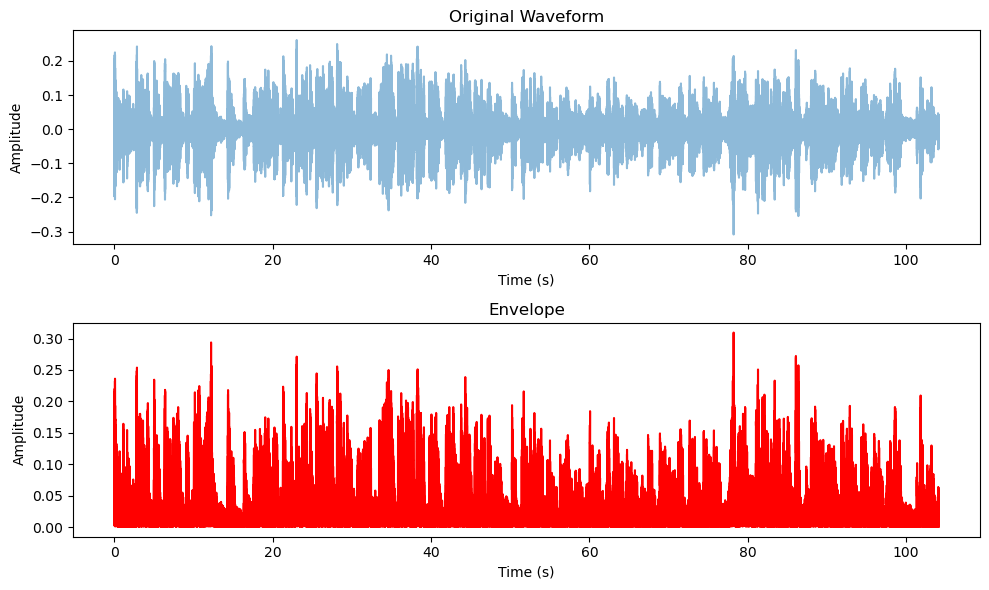

In [15]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, filtfilt

audio_path = 'test.mp3'
y, sr = librosa.load(audio_path)

analytic_signal = hilbert(y)

envelope = np.abs(analytic_signal)

time = np.arange(0, len(y)) / sr

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time, y, alpha=0.5)
plt.title('Original Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time, envelope, color='red')
plt.title('Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

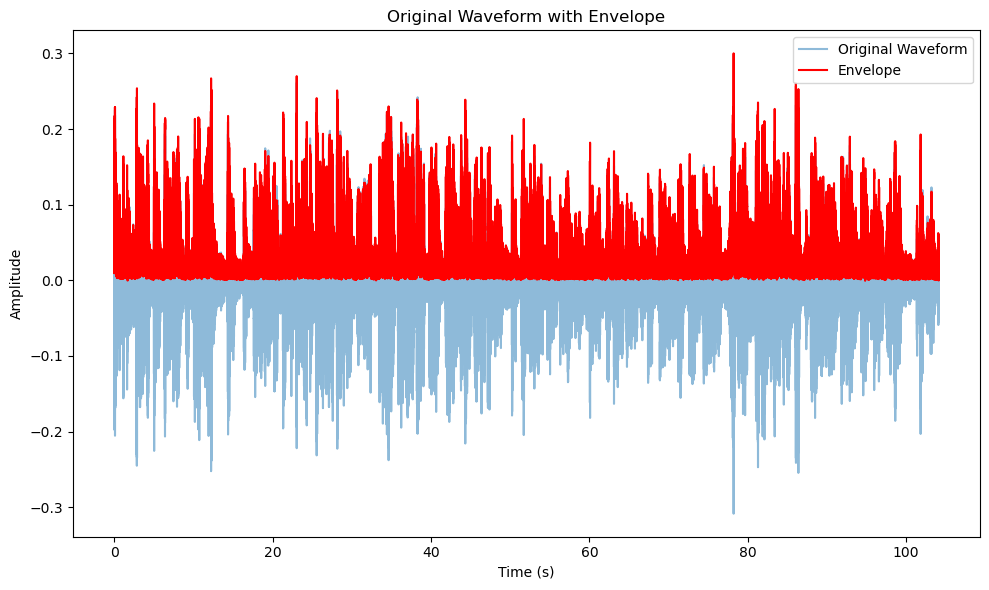

In [19]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

# Load the audio file
audio_path = 'test.mp3'
y, sr = librosa.load(audio_path)

# Calculate the analytic signal using the Hilbert transform
analytic_signal = hilbert(y)

# Calculate the envelope as the magnitude of the analytic signal
envelope = np.abs(analytic_signal)

# Set up a low-pass Butterworth filter
order = 5  # Filter order
cutoff_frequency = 1000  # Adjust cutoff frequency as needed
b, a = butter(order, cutoff_frequency, 'low', fs=sr)

# Apply the filter using filtfilt
smoothed_envelope = filtfilt(b, a, envelope)

# Create a time array
time = np.arange(0, len(y)) / sr

# Plot the original waveform
plt.figure(figsize=(10, 6))
plt.plot(time, y, alpha=0.5, label='Original Waveform')

# Plot the smoothed envelope over the waveform as a line curve
plt.plot(time, smoothed_envelope, color='red', label='Envelope')

plt.title('Original Waveform with Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()  # Show legend

plt.tight_layout()
plt.show()



22050


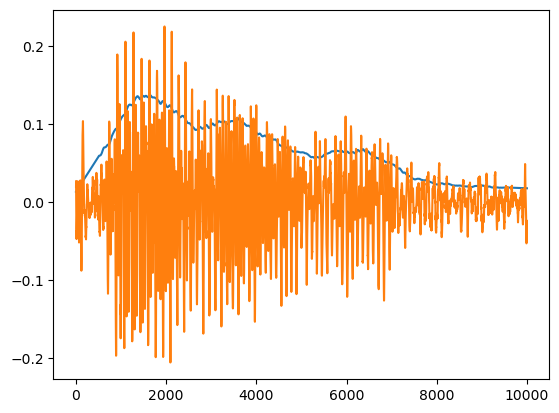

In [43]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, find_peaks, savgol_filter
from scipy.interpolate import interp1d

# Load the audio file
audio_path = 'test.mp3'
y, sr = librosa.load(audio_path)

print(sr)

# Calculate the analytic signal using the Hilbert transform
analytic_signal = hilbert(y)

env = np.abs(analytic_signal[:10000])

env = savgol_filter(env, 1000, 1)
plt.plot(env)
plt.plot(y[:10000])

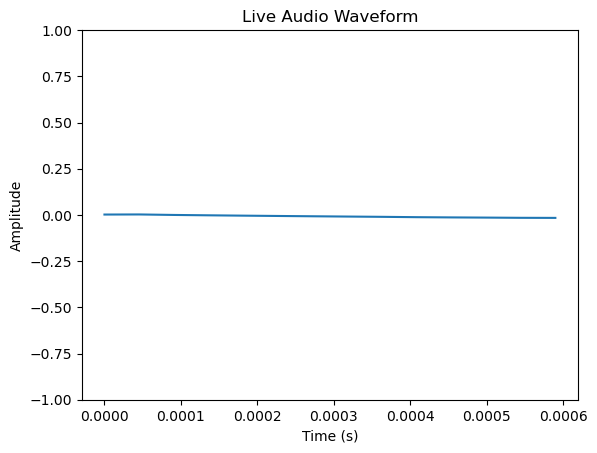

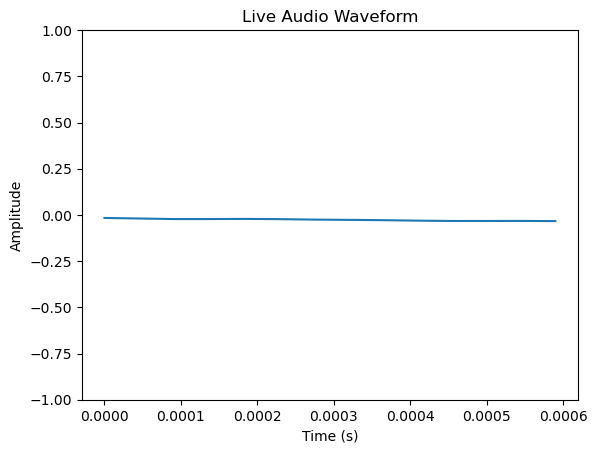

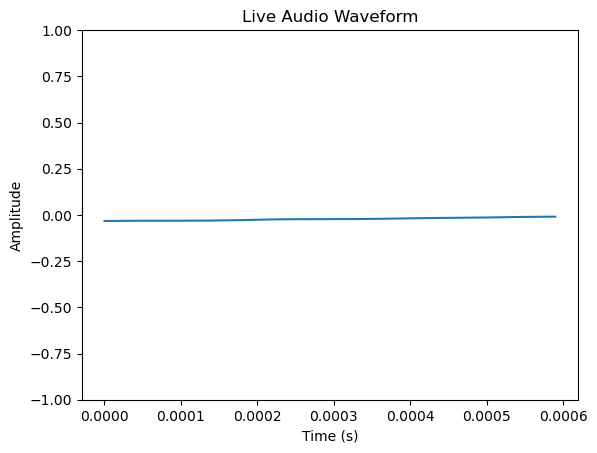

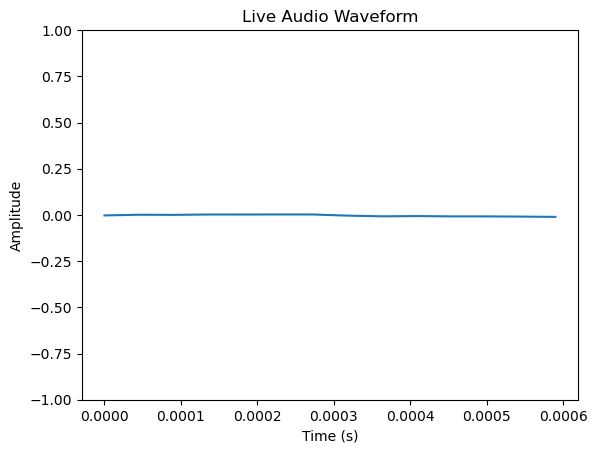

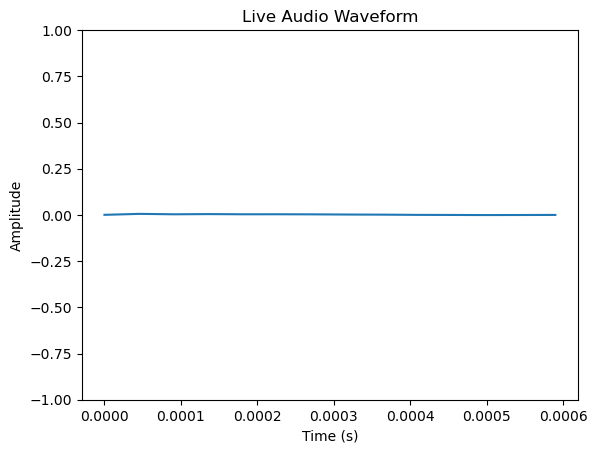

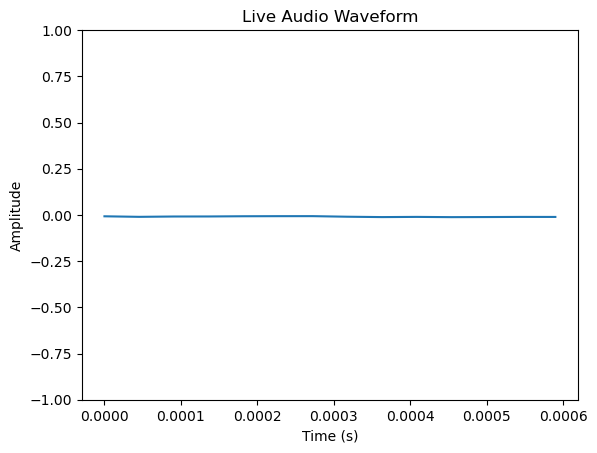

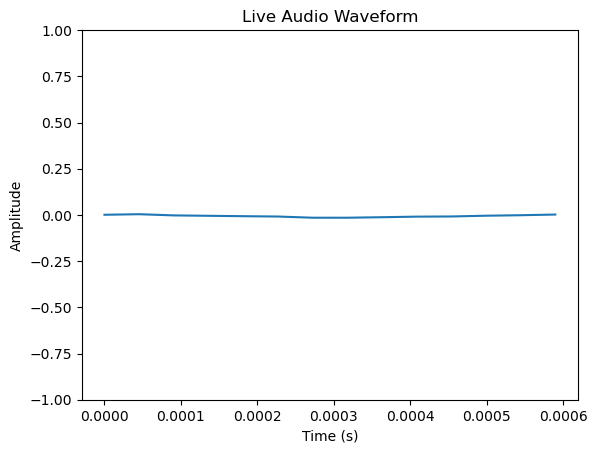

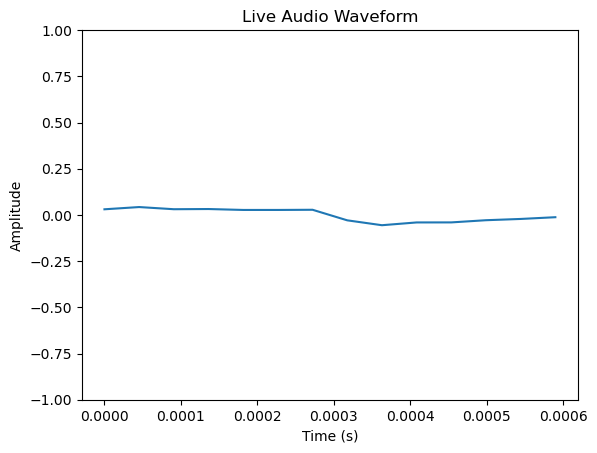

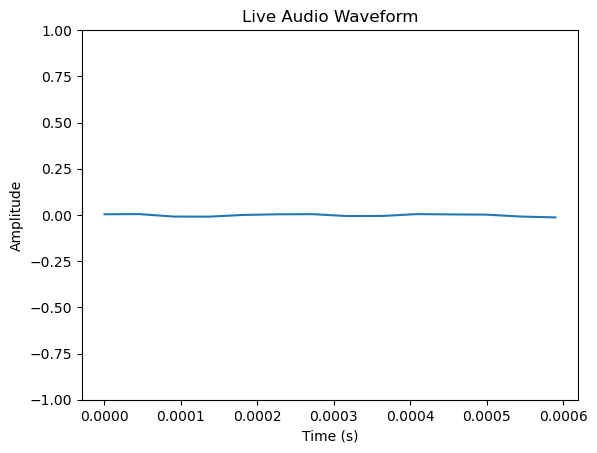

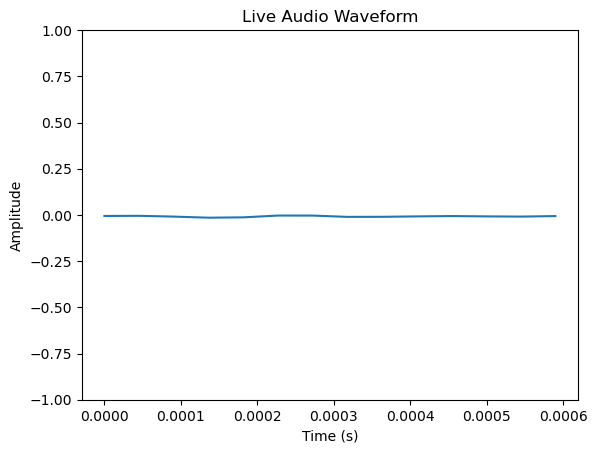

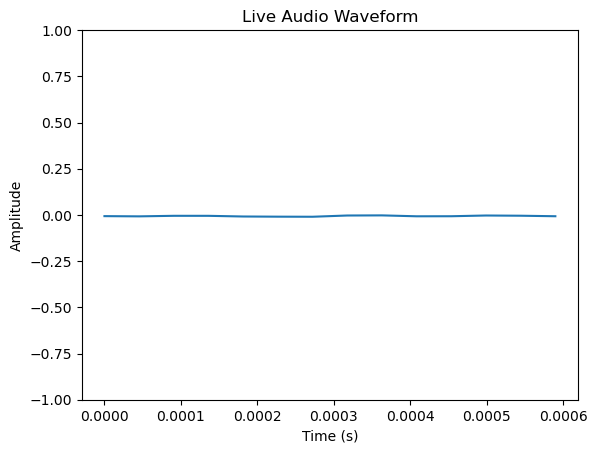

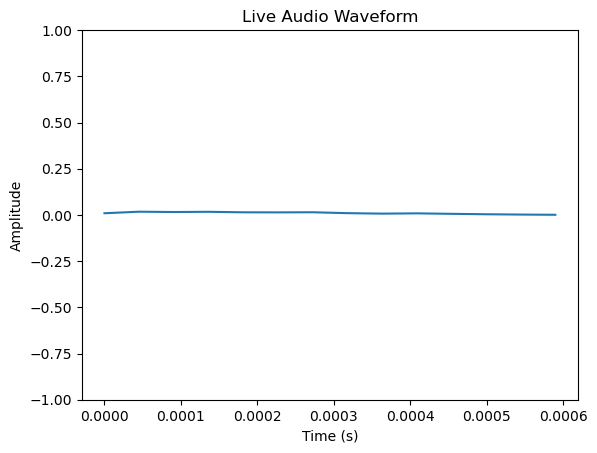

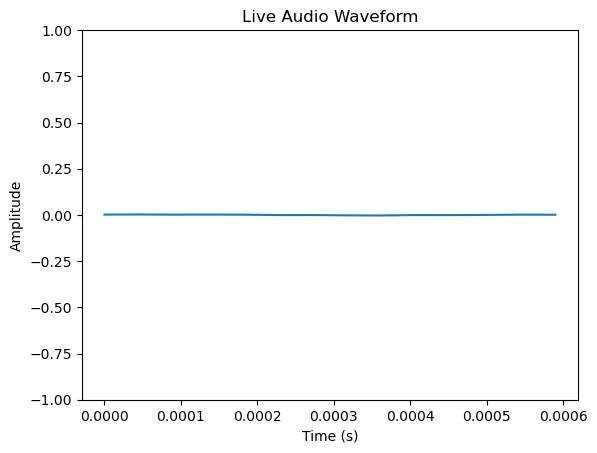

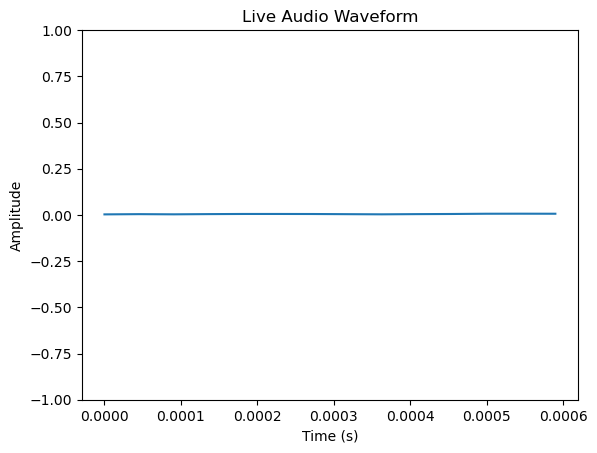

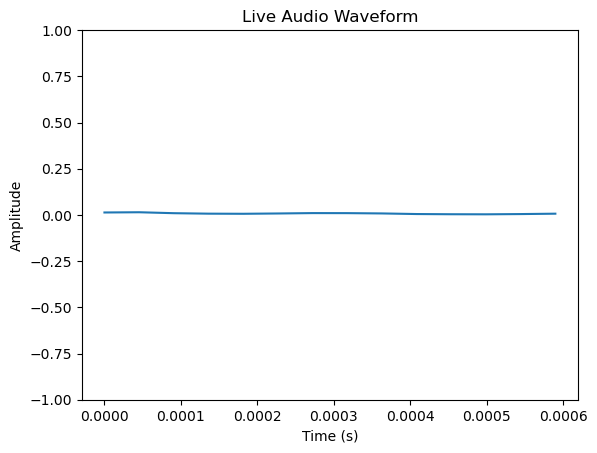

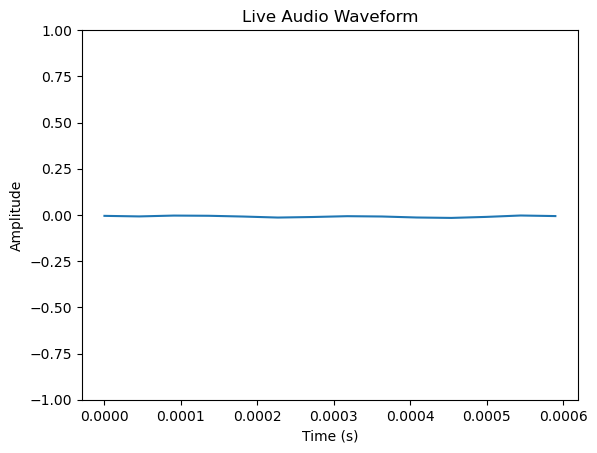

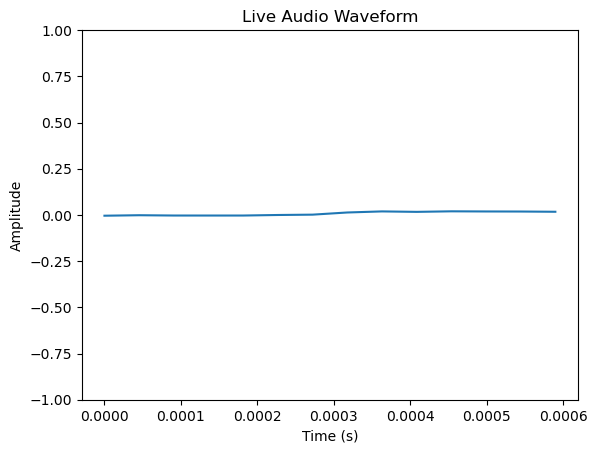

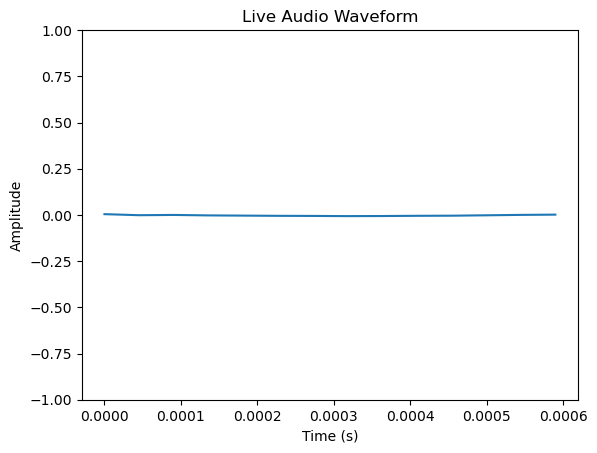

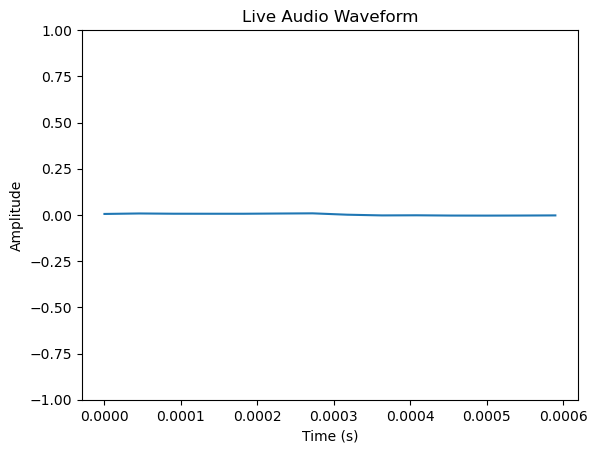

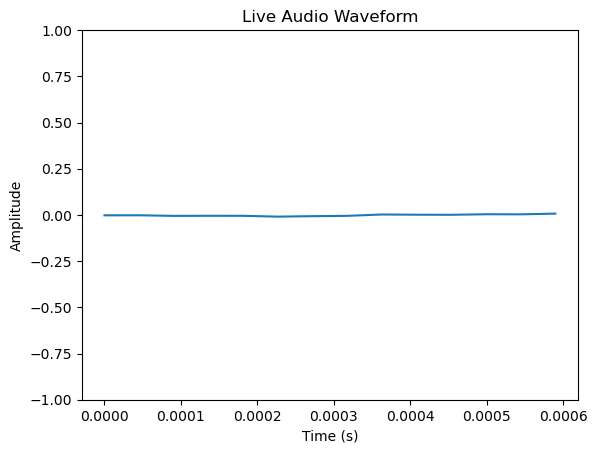

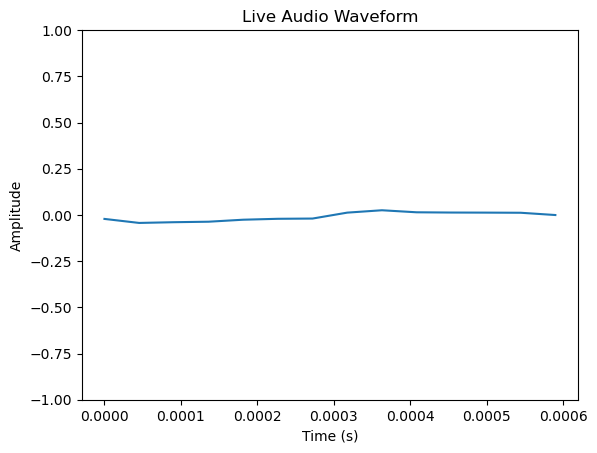

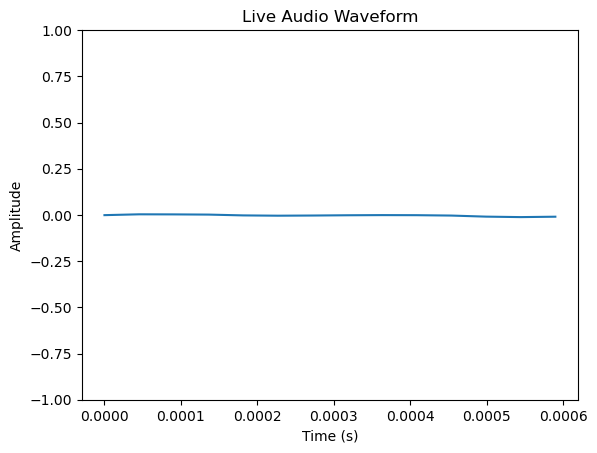

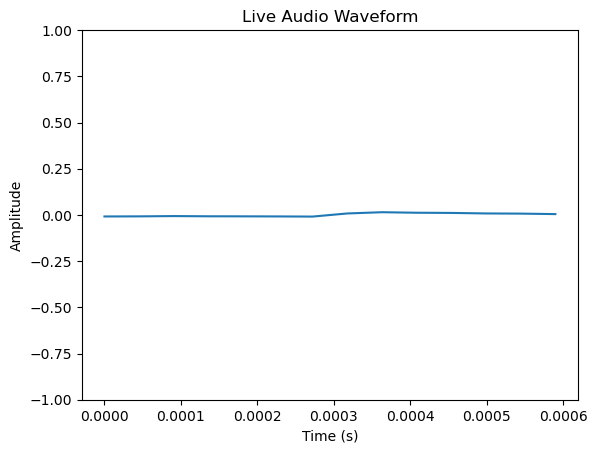

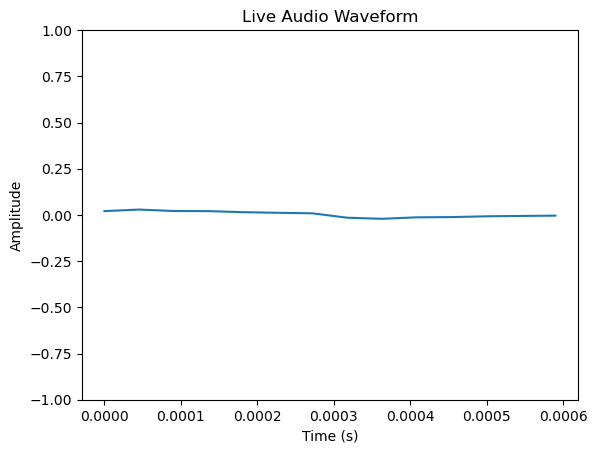

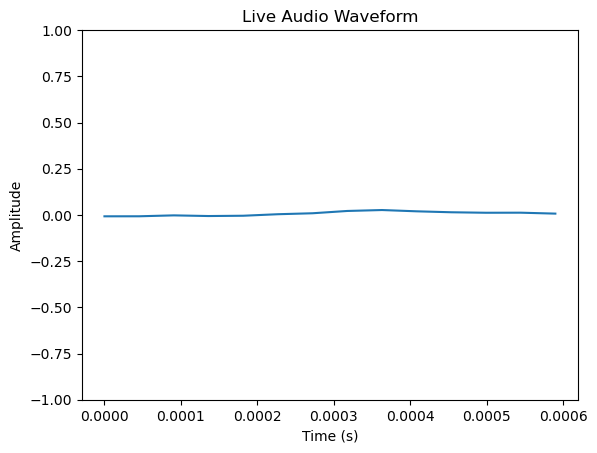

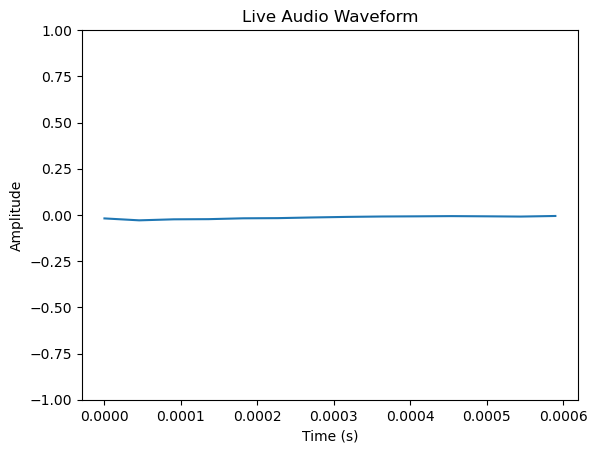

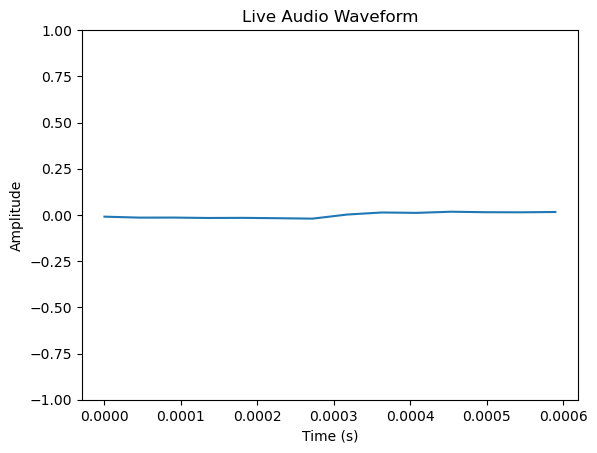

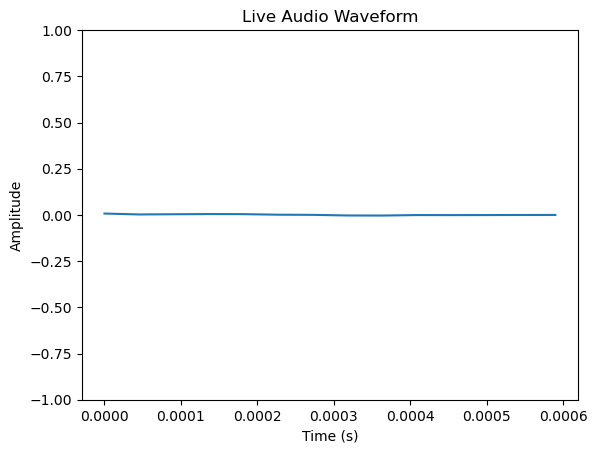

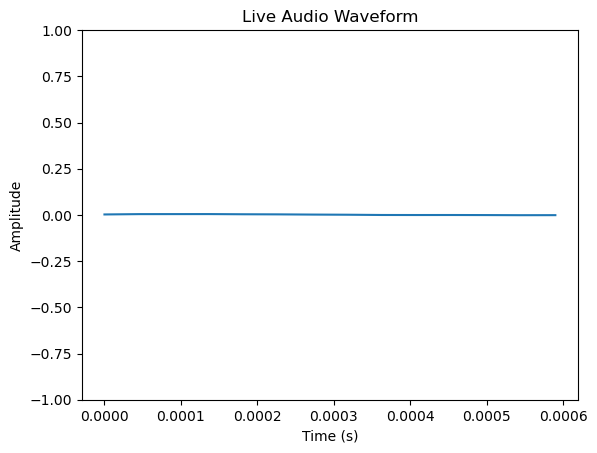

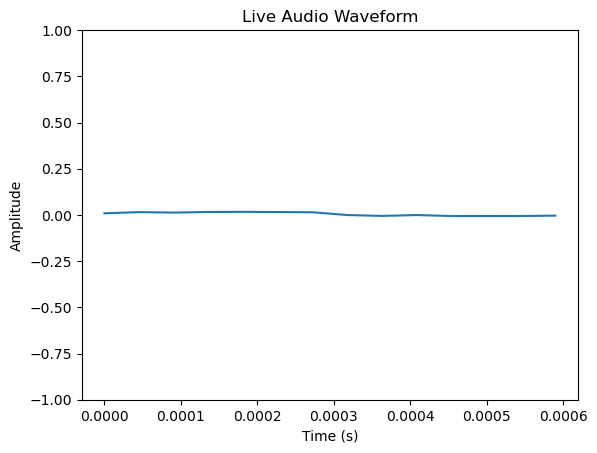

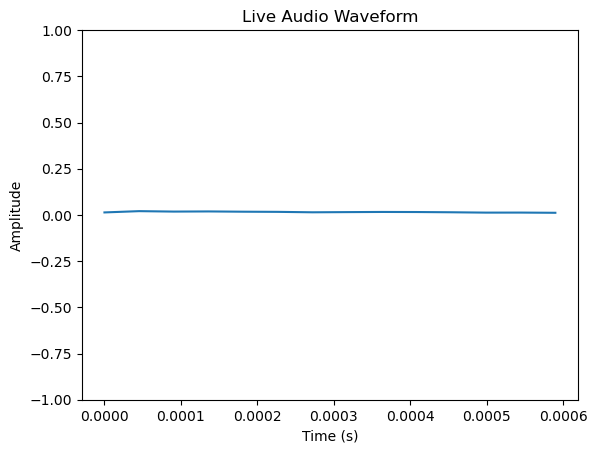

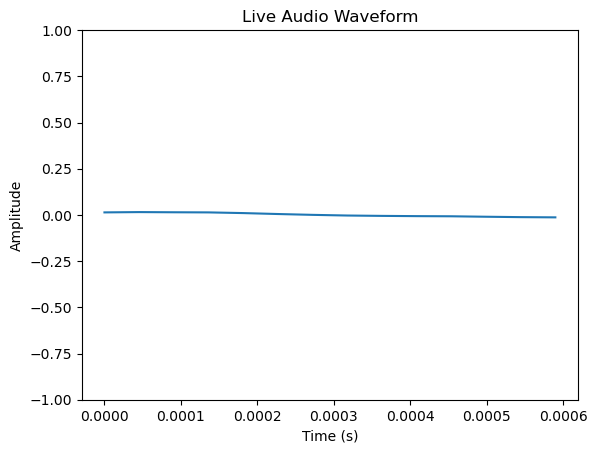

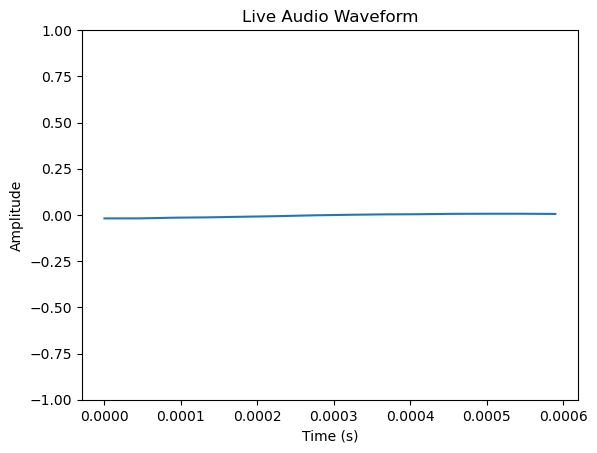

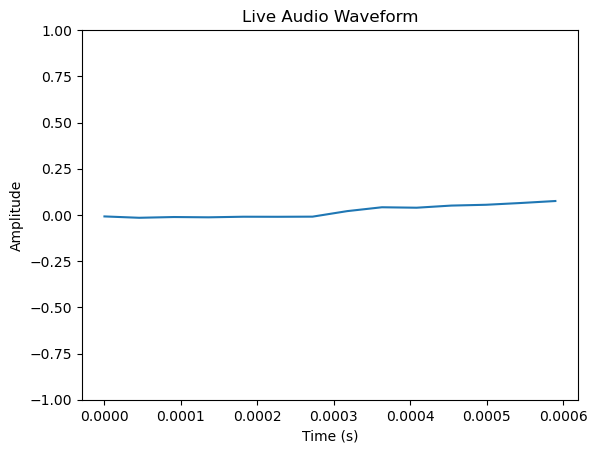

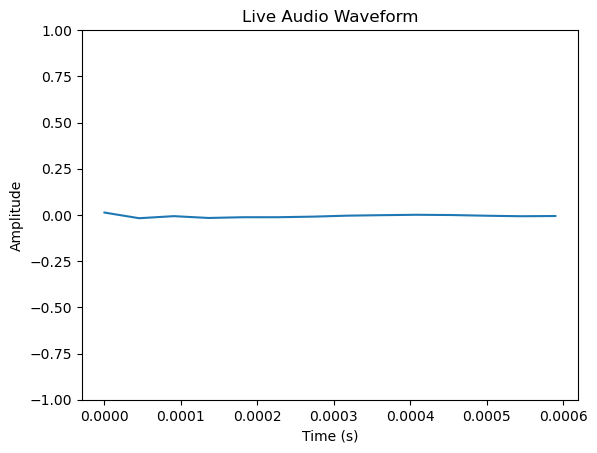

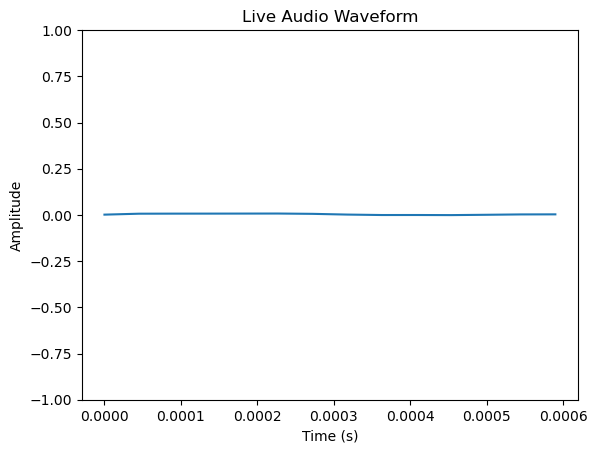

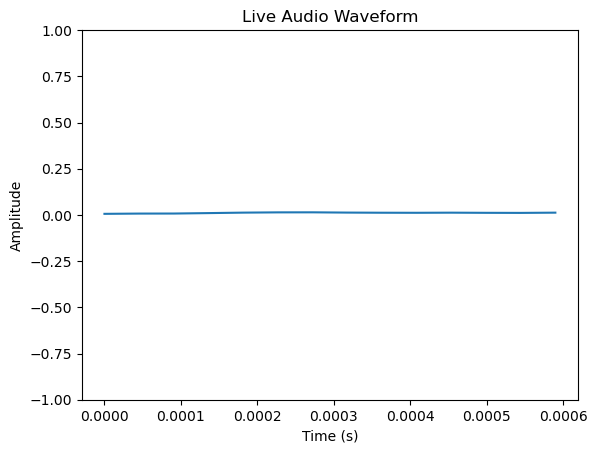

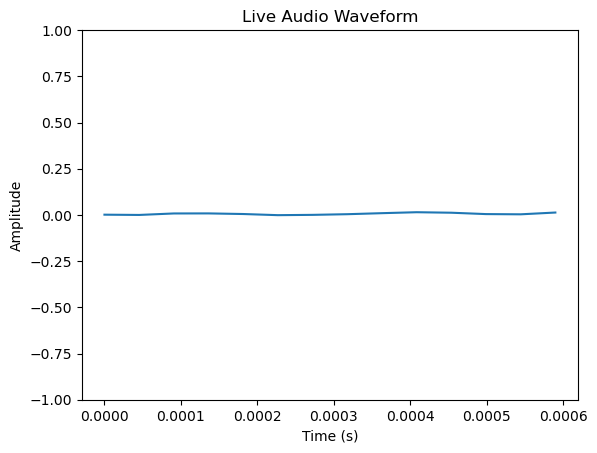

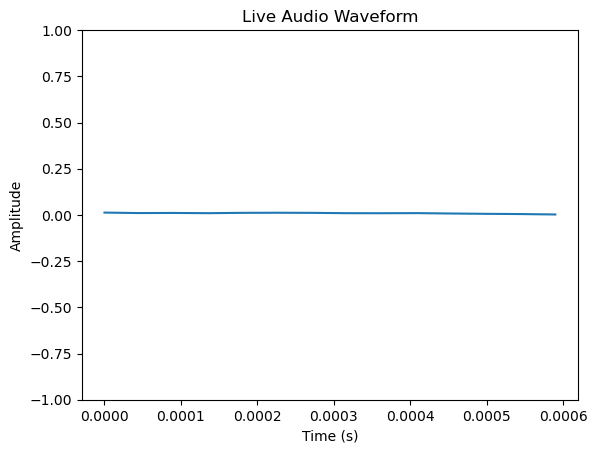

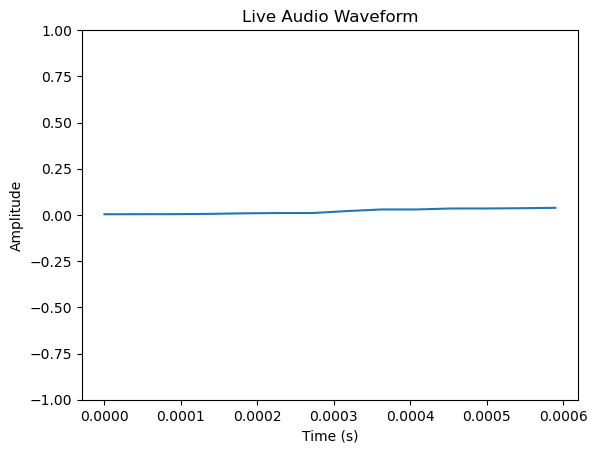

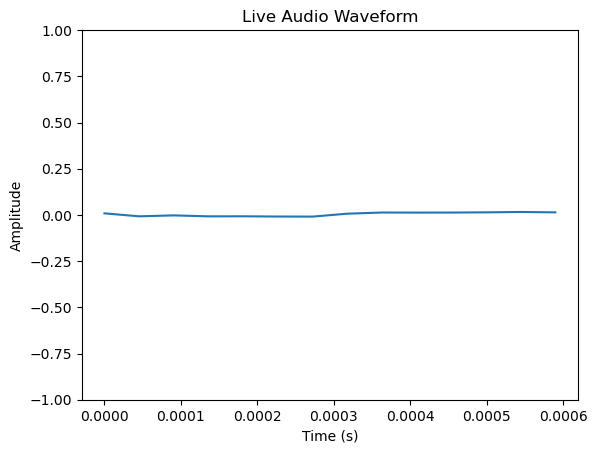

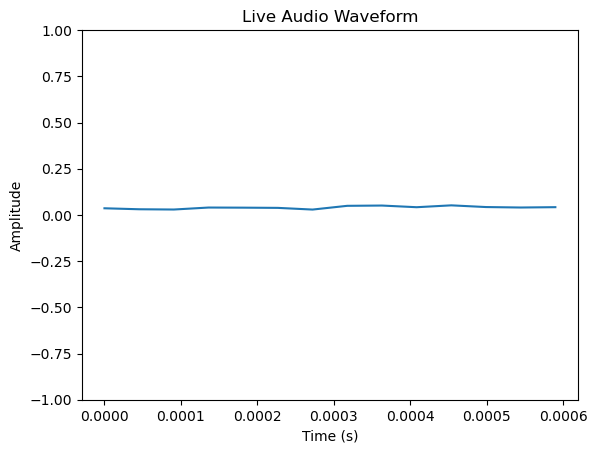

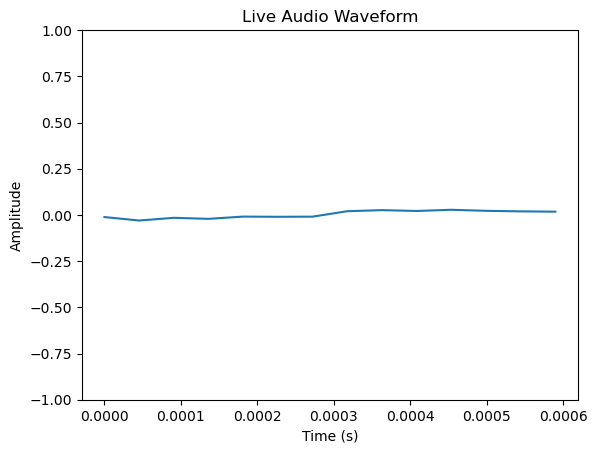

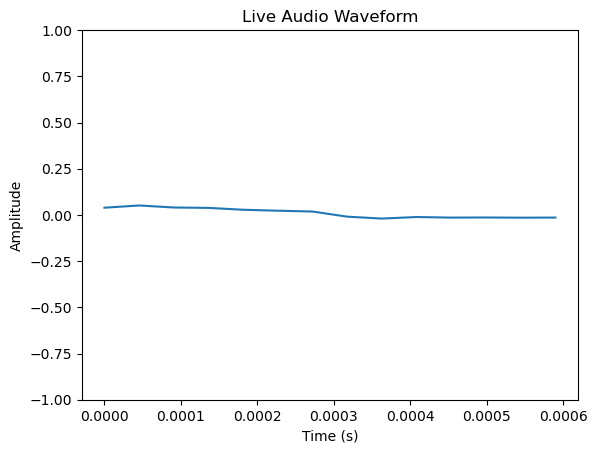

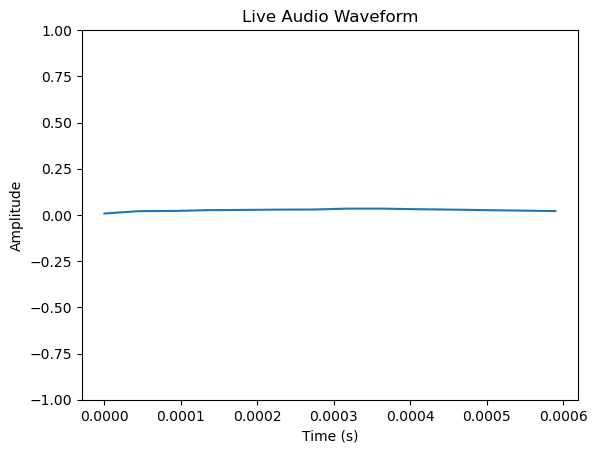

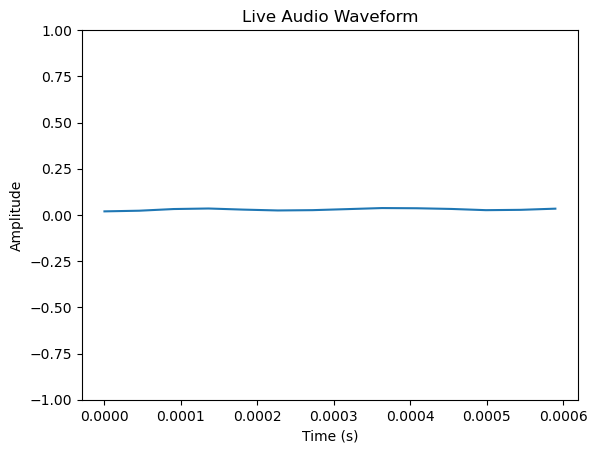

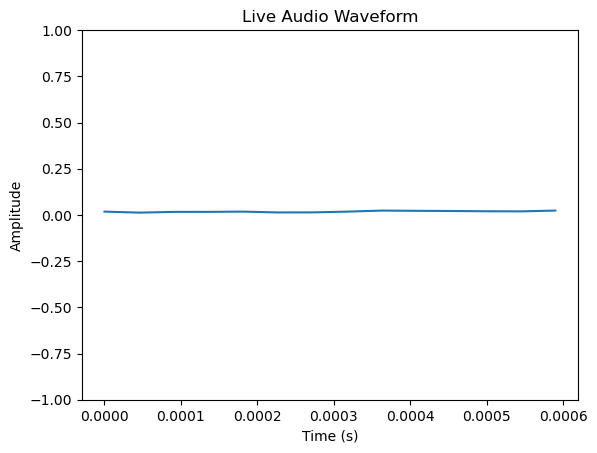

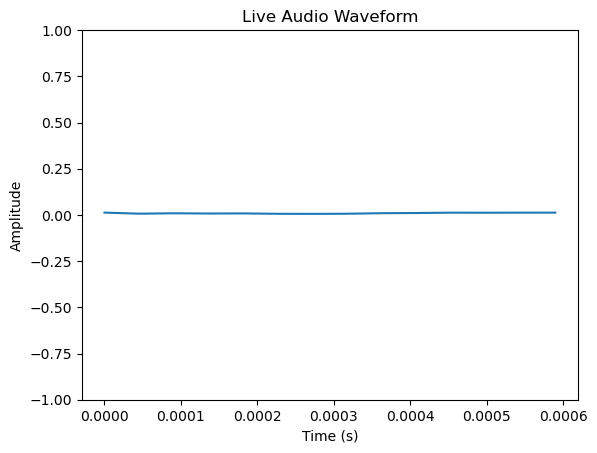

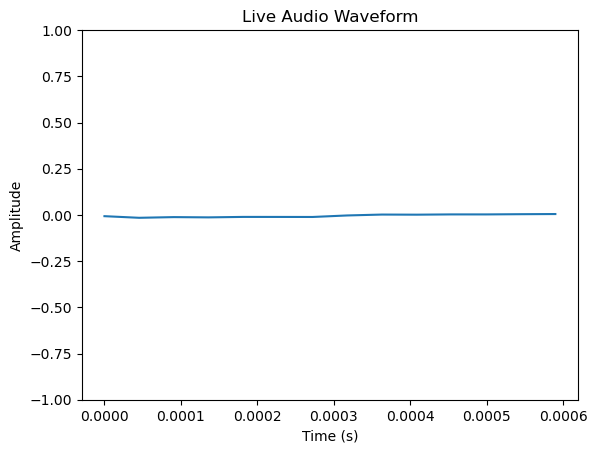

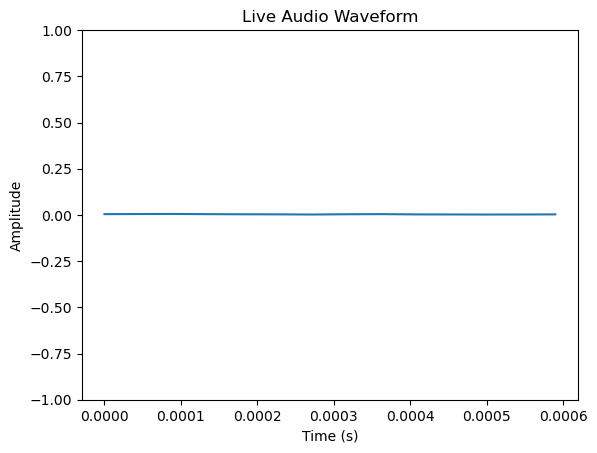

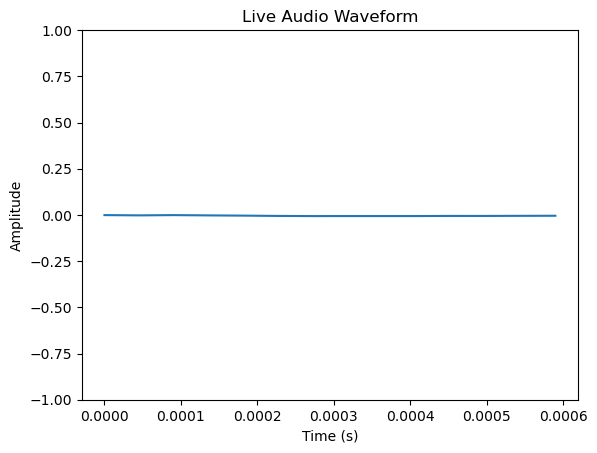

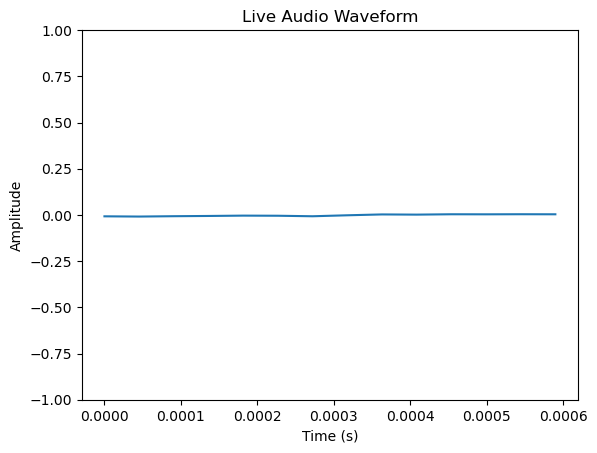

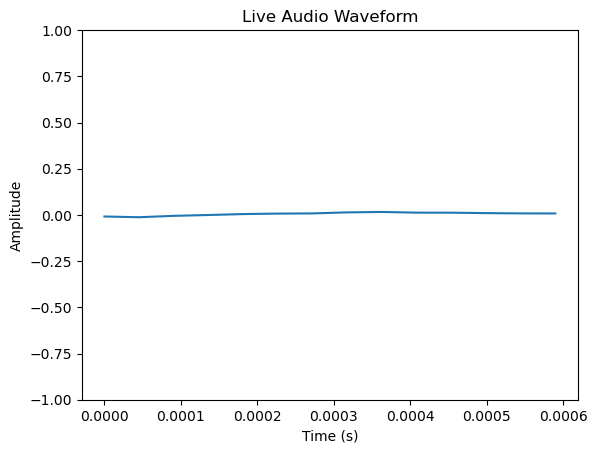

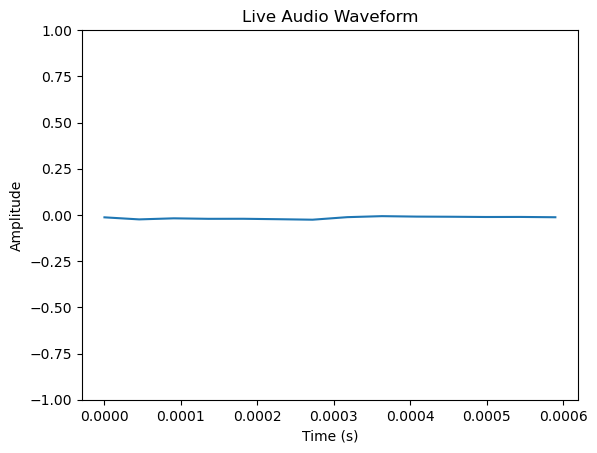

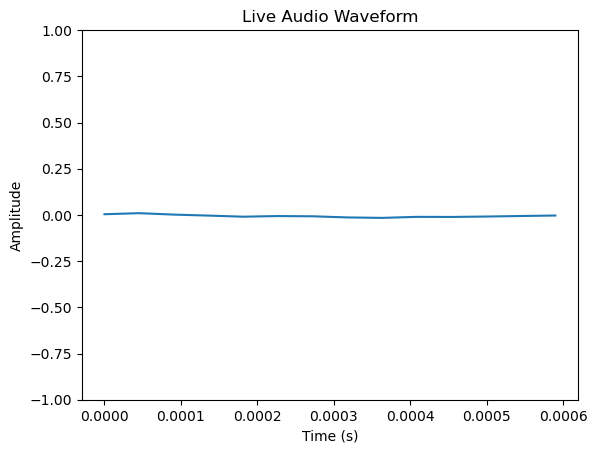

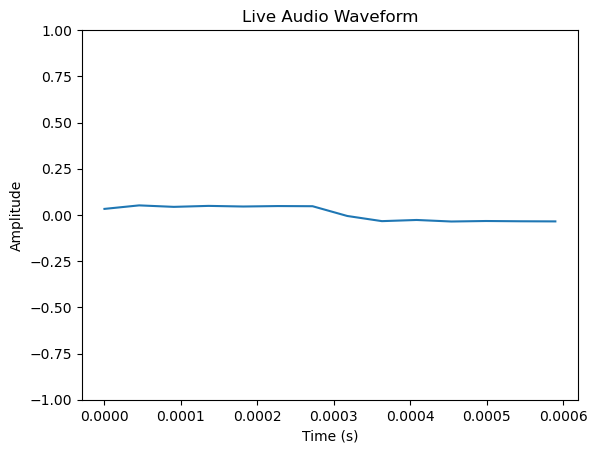

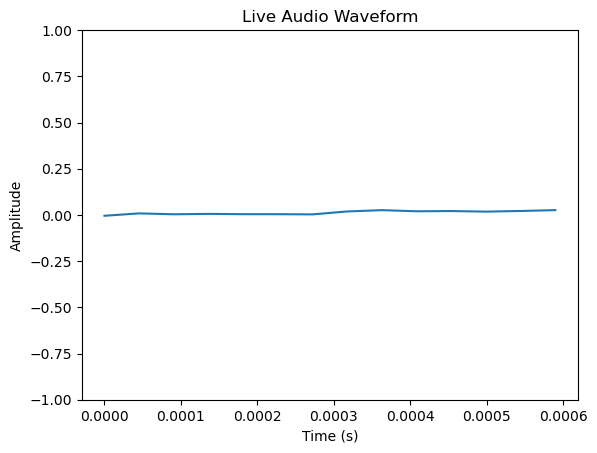

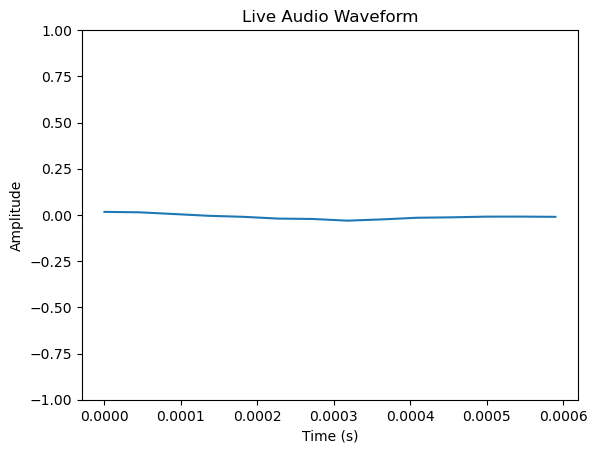

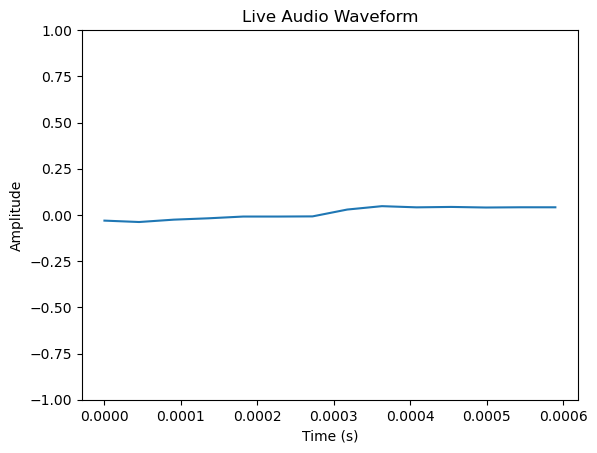

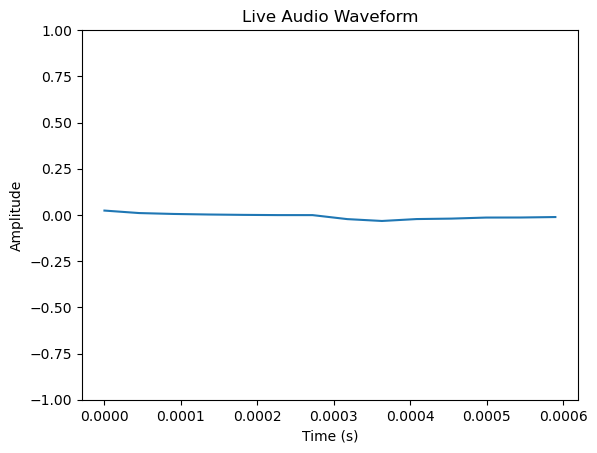

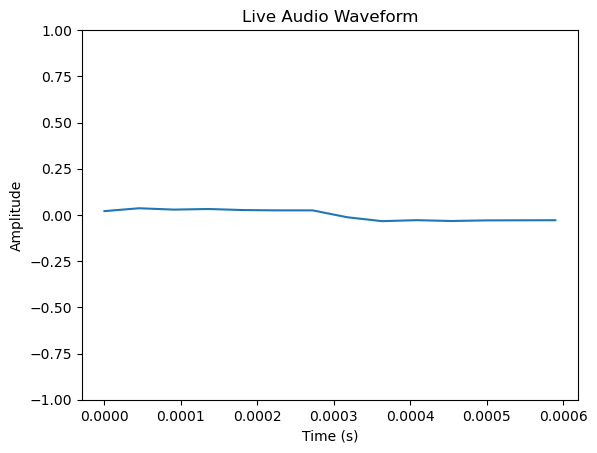

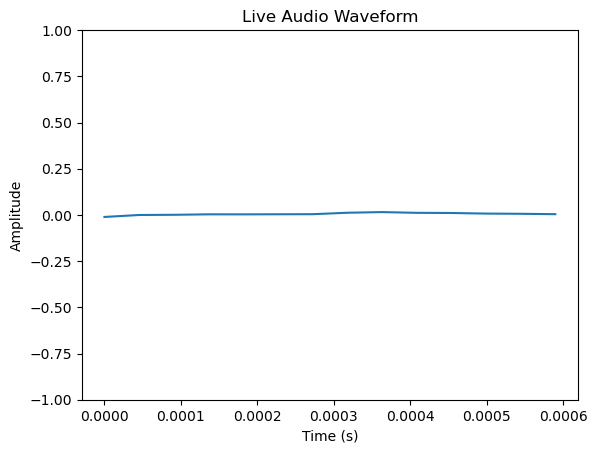

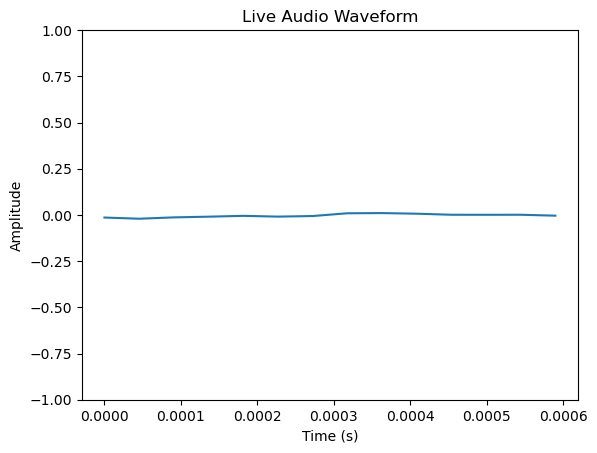

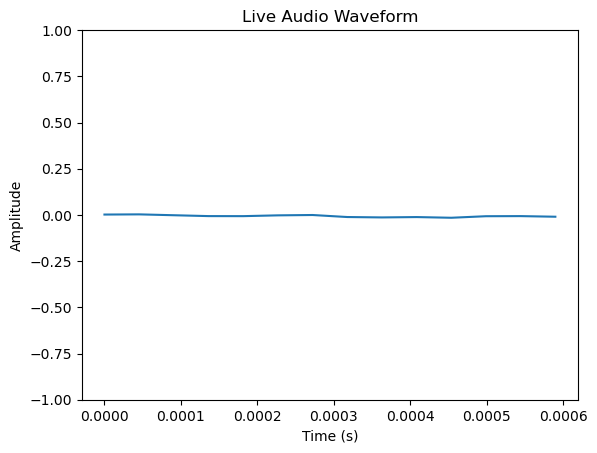

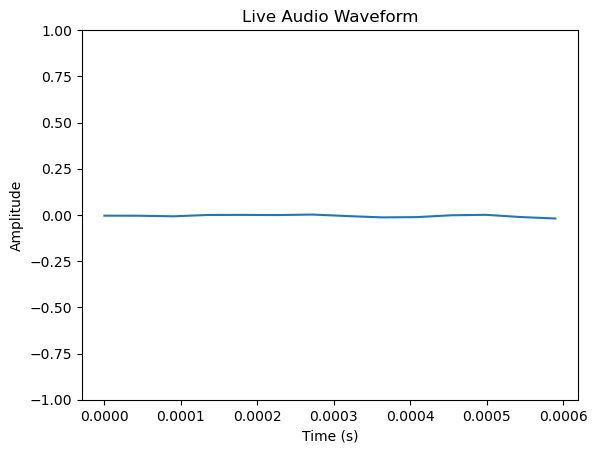

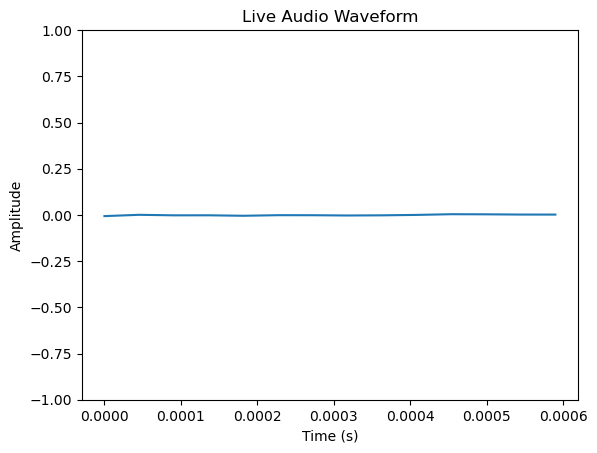

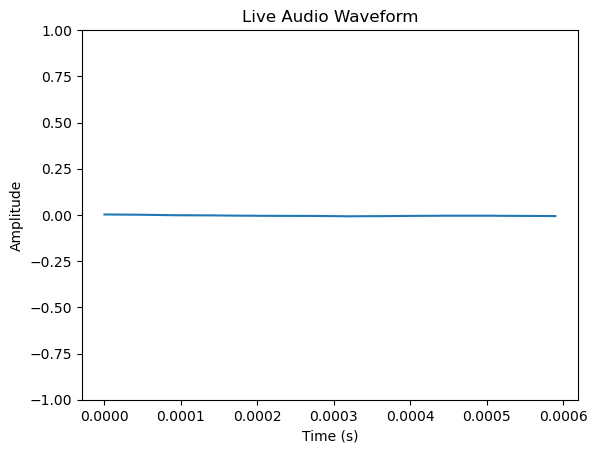

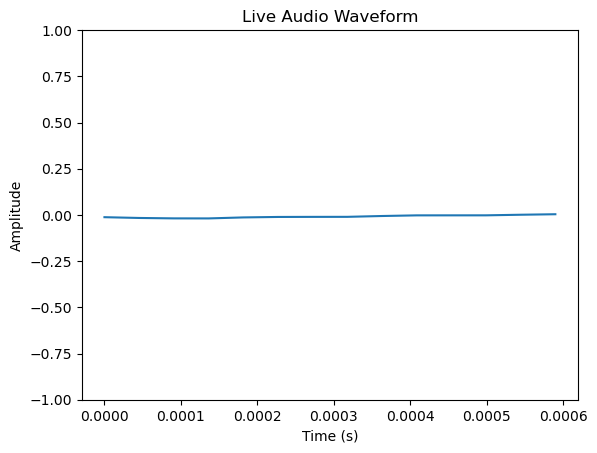

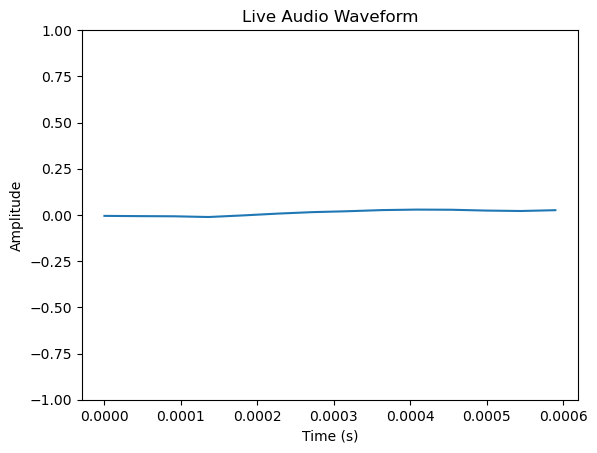

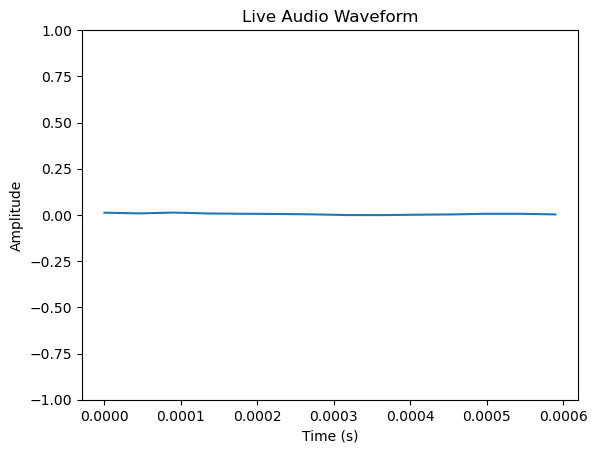

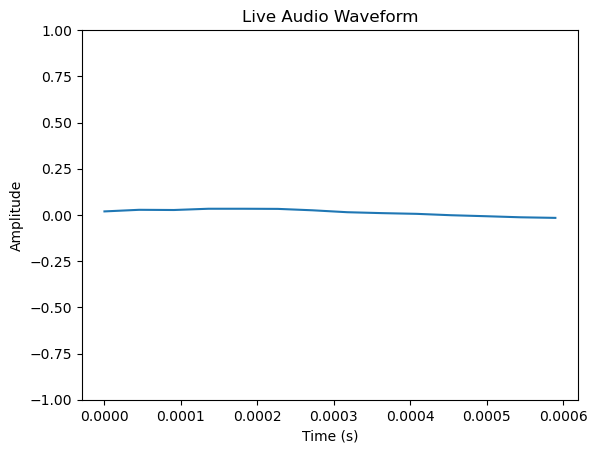

In [18]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import hilbert, savgol_filter

# Define parameters for audio recording
duration = 10  # Duration of audio recording in seconds
sample_rate = 22050  # Sample rate in Hz

# Function to handle audio input stream
def audio_callback(indata, frames, time, status):
    if status:
        print('Error:', status)
    # Plot the waveform
    plt.clf()
    plt.plot(np.arange(len(indata)) / sample_rate, indata)
    plt.title('Live Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(-1, 1)
    plt.pause(0.001)

    # plot the envelope
    analytic_signal = hilbert(indata[:, 0])
    envelope = np.abs(analytic_signal)
    envelope = savgol_filter(envelope, len(analytic_signal), 1)

    # plt.plot(np.arange(len(envelope)) / sample_rate, envelope)

# Start the audio stream
with sd.InputStream(callback=audio_callback,
                     samplerate=sample_rate,
                     channels=1):
    sd.sleep(int(duration * 1000))

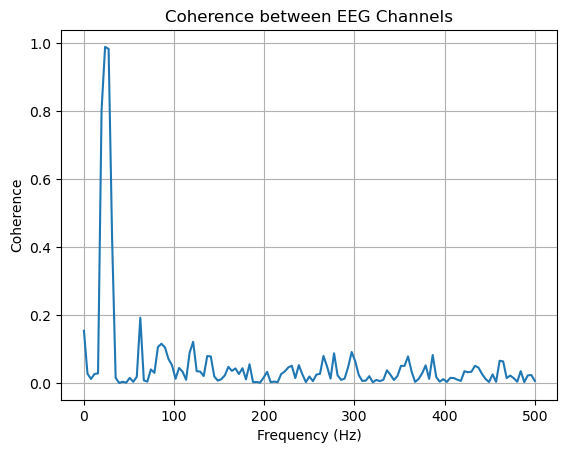

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Generate synthetic EEG signals for two channels
fs = 1000
T = 5
t = np.arange(0, T, 1/fs)
channel1 = np.sin(5 * np.pi * 10 * t) + np.random.normal(scale=0.5, size=len(t))
channel2 = np.sin(5 * np.pi * 10 * t + np.pi/4) + np.random.normal(scale=0.5, size=len(t))

# Calculate coherence between EEG channels
f, Cxy = signal.coherence(channel1, channel2, fs)

# Plot coherence
plt.figure()
plt.plot(f, Cxy)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Coherence between EEG Channels')
plt.grid(True)
plt.show()

In [6]:
import sounddevice as sd
import numpy as np
from scipy.signal import hilbert, savgol_filter
import time

# Define parameters for audio recording
duration = 1  # Duration of audio recording in seconds
fs = 22050  # Sample rate in Hz

# Function to handle audio input stream
def audio_callback(indata, frames, time, status):
    if status:
        print('Error:', status)

    analytic_signal = hilbert(indata[:, 0])
    envelope = np.abs(analytic_signal)
    envelope = savgol_filter(envelope, len(analytic_signal), 1)
    print(len(envelope))

# Start the audio stream
with sd.InputStream(callback=audio_callback,
                     samplerate=fs,
                     blocksize=int(fs * duration),  # Set the block size to collect more data per frame
                     channels=1):
    while True:
        time.sleep(1)  # Sleep for 1 second for each iteration

22050
22050
22050
22050
22050
22050
22050


KeyboardInterrupt: 

||PaMacCore (AUHAL)|| Error on line 2523: err='-50', msg=Unknown Error
||PaMacCore (AUHAL)|| Error on line 2523: err='-50', msg=Unknown Error


In [12]:
import socket
import sys
import time
import argparse
import signal
import struct
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import sounddevice as sd
from scipy.signal import hilbert, savgol_filter, coherence

raw_pulse_signal = []
all_data = []

# Print received message to console
def print_message(*args):
    try:
        # print(args[0]) #added to see raw data
        data = json.loads(args[0].decode()).get('data')
        averages = []
        for i in np.arange(5):
            sum = 0
            for j in np.arange(8):
                sum += data[j][i]
            averages.append(sum/8)
        return averages

    except BaseException as e:
        print(e)


#  print("(%s) RECEIVED MESSAGE: " % time.time() +
# ''.join(str(struct.unpack('>%df' % int(length), args[0]))))

# Clean exit from print mode
def exit_print(signal, frame):
    print("Closing listener")
    sys.exit(0)


# Record received message in text file
def record_to_file(*args):
    textfile.write(str(time.time()) + ",")
    # textfile.write(''.join(str(struct.unpack('>%df' % length, args[0]))))
    textfile.write(str(json.loads(args[0].decode()).get('data')))
    textfile.write("\n")


# Save recording, clean exit from record mode
def close_file(*args):
    print("\nFILE SAVED")
    textfile.close()
    sys.exit(0)

def run_main():
    # Collect command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--ip",
                        default="127.0.0.1", help="The ip to listen on")
    parser.add_argument("--port",
                        type=int, default=12346, help="The port to listen on")
    parser.add_argument("--address", default="/openbci", help="address to listen to")
    parser.add_argument("--option", default="print", help="Debugger option")
    parser.add_argument("--len", default=8, help="Debugger option")
    args = parser.parse_args()

    # Set up necessary parameters from command line
    length = args.len
    if args.option == "print":
        signal.signal(signal.SIGINT, exit_print)
    elif args.option == "record":
        i = 0
        while os.path.exists("udp_test%s.txt" % i):
            i += 1
        filename = "udp_test%i.txt" % i
        textfile = open(filename, "w")
        textfile.write("time,address,messages\n")
        textfile.write("-------------------------\n")
        print("Recording to %s" % filename)
        signal.signal(signal.SIGINT, close_file)

    # Connect to socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server_address = (args.ip, args.port)
    sock.bind(server_address)

    # Display socket attributes
    print('--------------------')
    print("-- UDP LISTENER -- ")
    print('--------------------')
    print("IP:", args.ip)
    print("PORT:", args.port)
    print('--------------------')
    print("%s option selected" % args.option)

    # Receive messages
    print("Listening...")
    sec_data = []
    for i in np.arange(5):
        sec_data.append([])
    start = time.time()
    numSamples = 0
    sample_size = np.inf
    duration = np.inf
    fs = 22050

    def audio_callback(indata, frames, time, status):
        if status:
            print('Error:', status)

        analytic_signal = hilbert(indata[:, 0])
        envelope = np.abs(analytic_signal)
        envelope = savgol_filter(envelope, len(analytic_signal), 1)

        coherence_results = []
        for i in sec_data:
            f, Cxy = coherence(envelope, i, fs)
            max_c = np.max(Cxy)
            max_f = f[np.argmax(Cxy)]
            coherence_results.append([max_c, max_f])
        
        print(coherence_results)

        sec_data = []
        for i in np.arange(5):
            sec_data.append([])

    while (time.time() <= start + duration) and (numSamples < sample_size):
        # with sd.InputStream(callback=audio_callback,
        #         samplerate=fs,
        #         blocksize=int(fs * duration),  # Set the block size to collect more data per frame
        #         channels=1):
        data, addr = sock.recvfrom(20000)  # buffer size is 20000 bytes
        # audio_data = sd.rec(int(1 * 22050), samplerate=fs, channels=1, dtype='float64')
        # sd.wait()  # Wait until recording is finished
        if args.option == "print":
            averages = print_message(data)
            for i in np.arange(5):
                sec_data[i].append(averages[i])
            
            numSamples += 1
            # audio_data = audio_data.flatten()

            # analytic_signal = hilbert(audio_data)
            # envelope = np.abs(analytic_signal)
            # envelope = savgol_filter(envelope, len(analytic_signal), 1)

            # print(sec_data)
            # coherence_results = []
            # for i in sec_data:
            #     f, Cxy = coherence(i, i, fs)
            #     max_c = np.max(Cxy)
            #     max_f = f[np.argmax(Cxy)]
            #     coherence_results.append([max_c, max_f])
            # print(coherence_results)
        elif args.option == "record":
            # record_to_file(data)
            textfile.write(str(time.time()) + ",")
            textfile.write(str(json.loads(args[0].decode()).get('data')[0]))
            textfile.write("\n")
        if (len(sec_data[0]) > 100):
            #random transform each value in sec data
            new_audio_sec_data = []
            for i in range(len(sec_data)):
                new_audio_sec_data.append(sec_data[i] * np.random.rand(len(sec_data[i])))
            
            coherence_results = []
            for i in range(len(new_audio_sec_data)):
                f, Cxy = coherence(sec_data[i], new_audio_sec_data[i], fs)
                max_c = np.max(Cxy)
                max_f = f[np.argmax(Cxy)]
                coherence_results.append([max_c, max_f])

            print(coherence_results)
            # plot the data
            plt.plot(sec_data[0])
            plt.ylabel('raw analog signal')

            sec_data = []
            for i in np.arange(5):
                sec_data.append([])

run_main()

usage: ipykernel_launcher.py [-h] [--ip IP] [--port PORT] [--address ADDRESS]
                             [--option OPTION] [--len LEN]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/arvind/Library/Jupyter/runtime/kernel-v2-38688neJvi1WY2gBN.json


SystemExit: 2

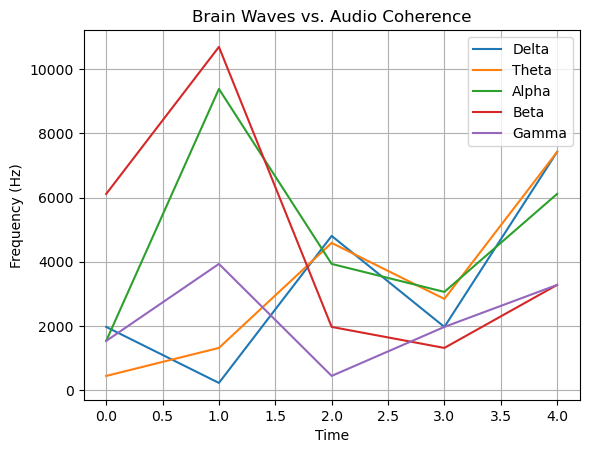

In [17]:
import matplotlib.pyplot as plt

# Define the arrays
arrays = [
    [[1.0000000000000007, 1964.851485148515], [1.0000000000000007, 218.31683168316832], [1.0000000000000004, 4802.970297029703], [1.0000000000000004, 1964.851485148515], [1.0000000000000007, 7422.772277227723]],
    [[1.0000000000000004, 436.63366336633663], [1.0000000000000004, 1309.90099009901], [1.0000000000000007, 4584.653465346535], [1.0000000000000004, 2838.1188118811883], [1.0000000000000007, 7422.772277227723]],
    [[1.0000000000000007, 1528.2178217821781], [1.0000000000000007, 9387.623762376237], [1.0000000000000004, 3929.70297029703], [1.0000000000000004, 3056.4356435643563], [1.0000000000000004, 6112.8712871287125]],
    [[1.0000000000000007, 6112.8712871287125], [1.0000000000000007, 10697.524752475247], [1.0000000000000007, 1964.851485148515], [1.0000000000000004, 1309.90099009901], [1.0000000000000009, 3274.7524752475247]],
    [[1.0000000000000004, 1528.2178217821781], [1.0000000000000004, 3929.70297029703], [1.0000000000000004, 436.63366336633663], [1.0000000000000002, 1964.851485148515], [1.000000000000, 3274.7524752475247]]]

# Plot the second value in each subarray as a line graph
for array in arrays:
    y = [point[1] for point in array]  # Extract the second value from each subarray
    plt.plot(y)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Brain Waves vs. Audio Coherence')
plt.legend(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])

# Show the plot
plt.grid(True)
plt.show()



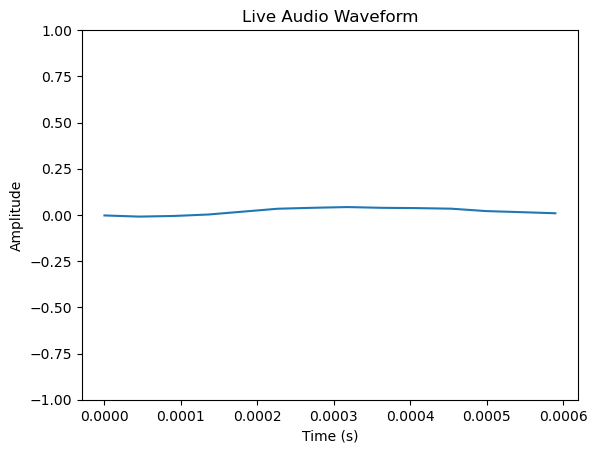

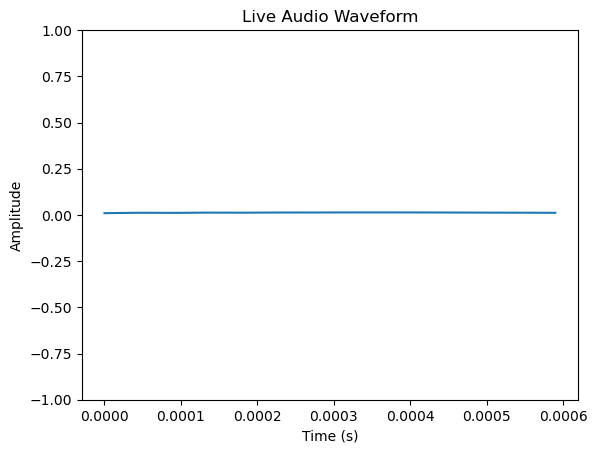

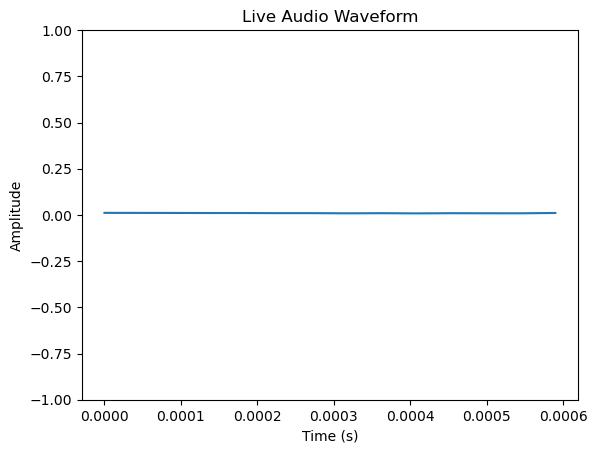

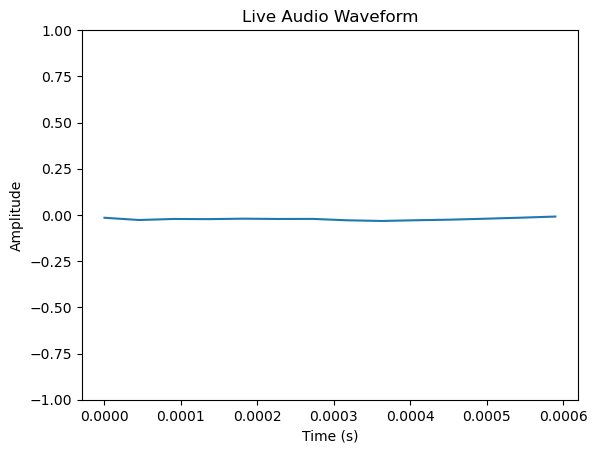

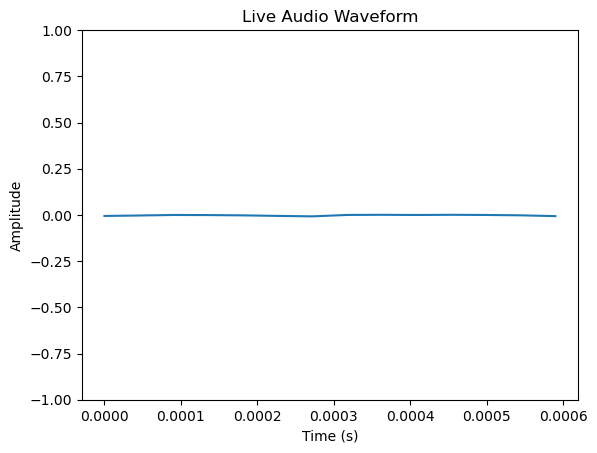

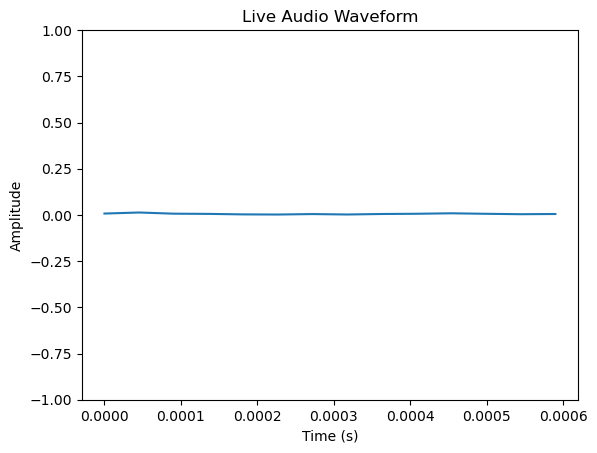

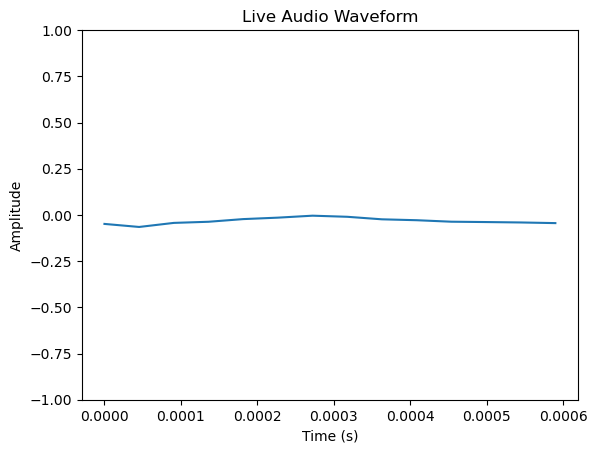

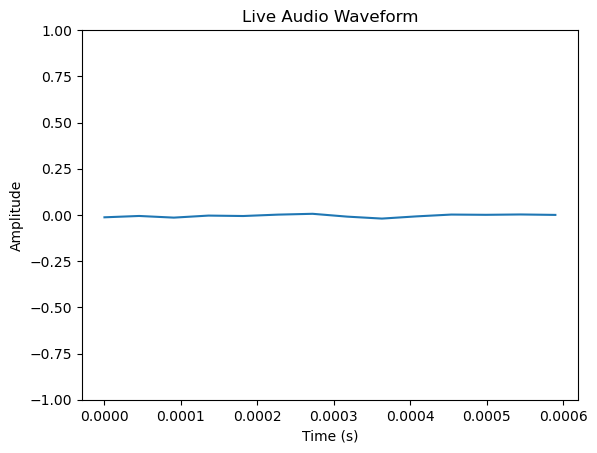

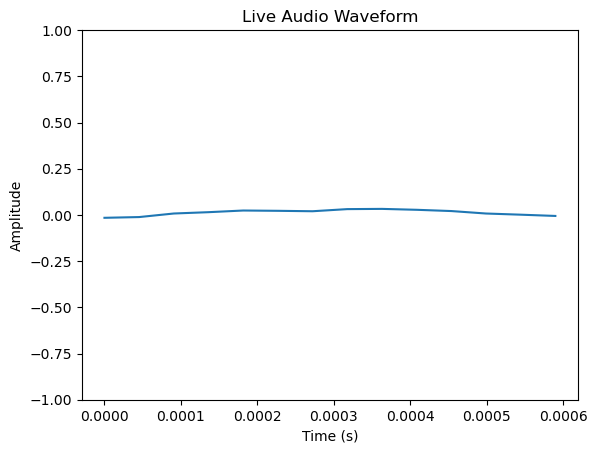

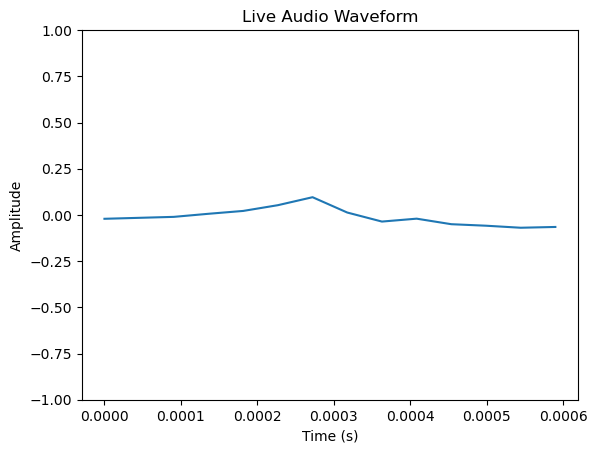

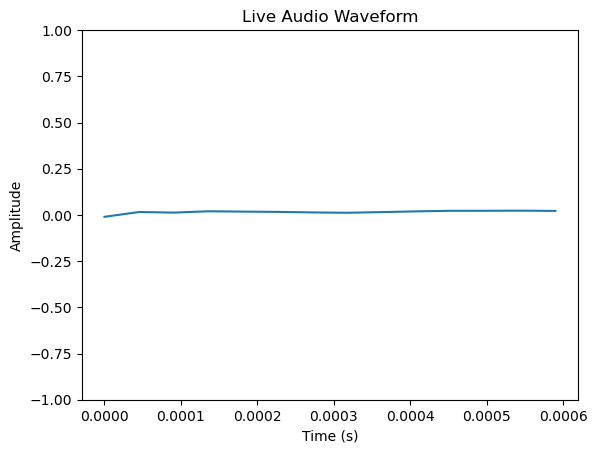

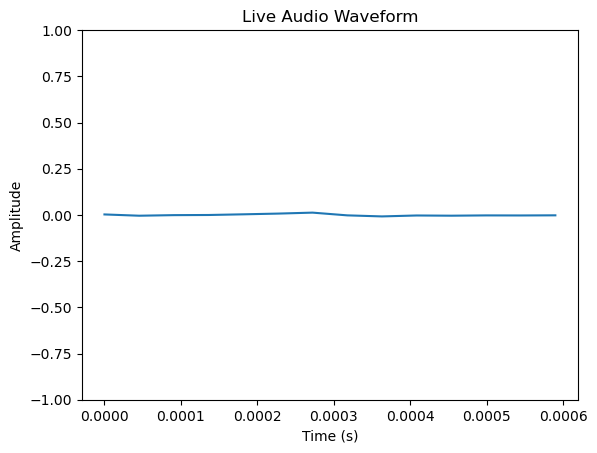

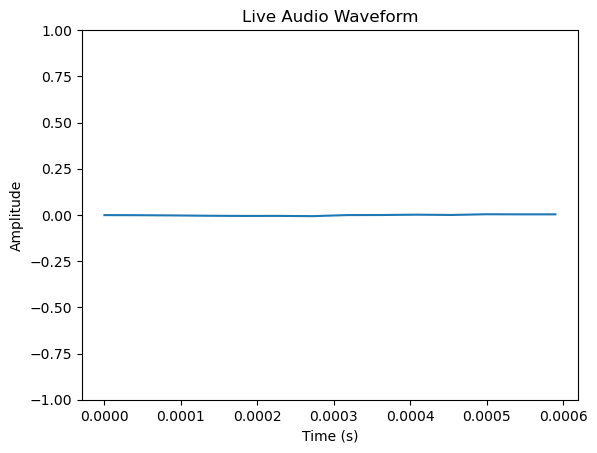

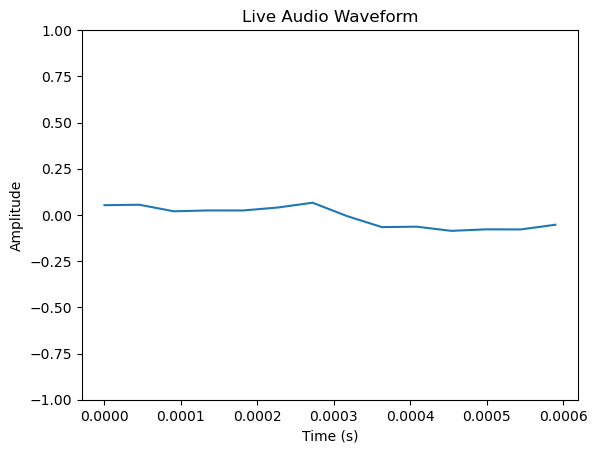

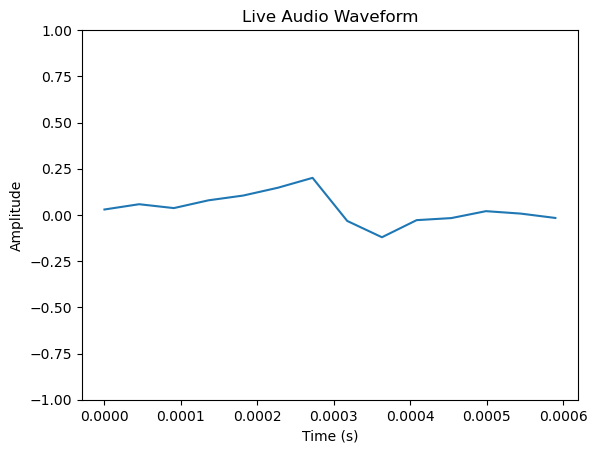

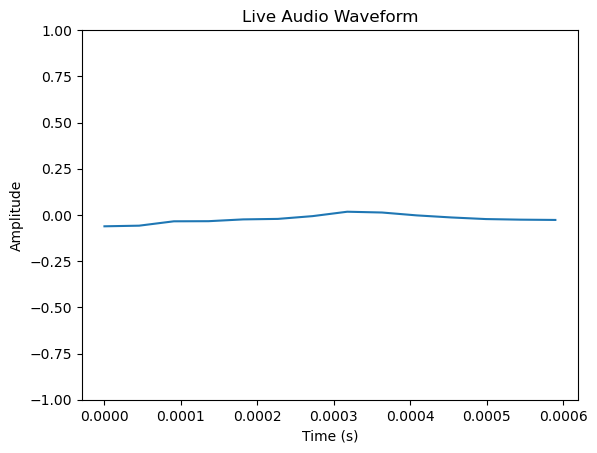

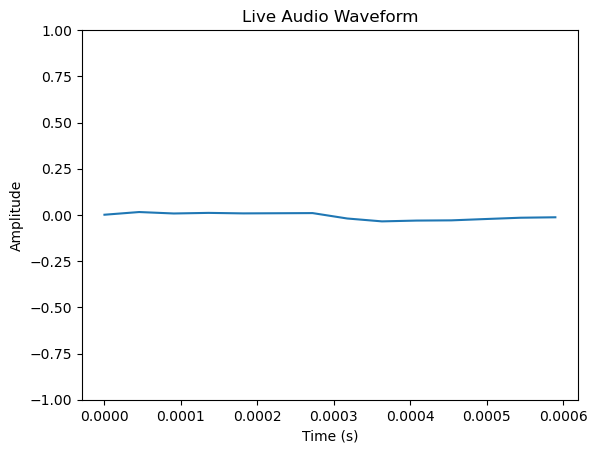

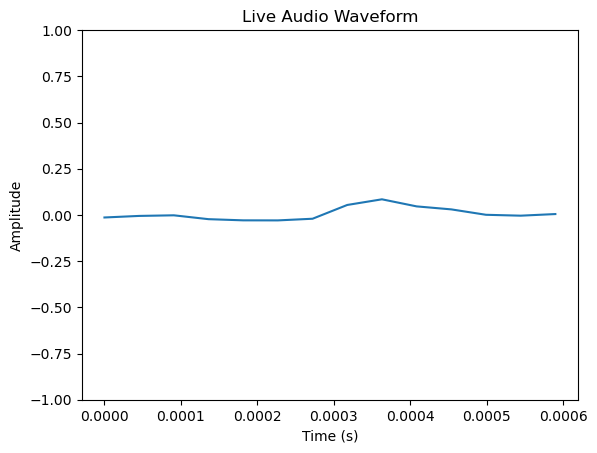

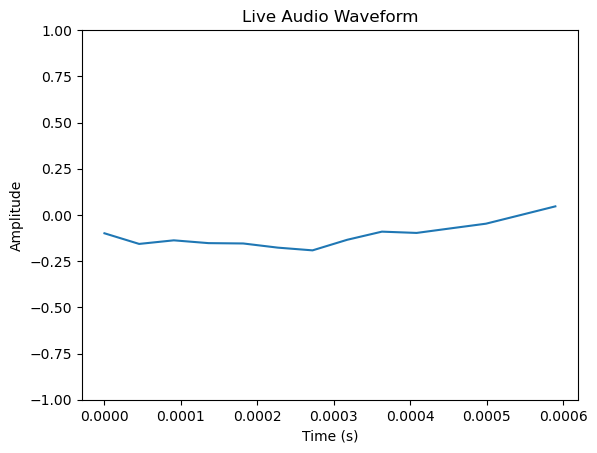

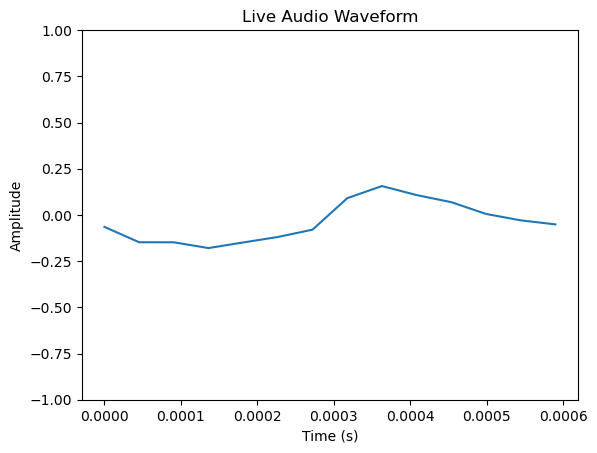

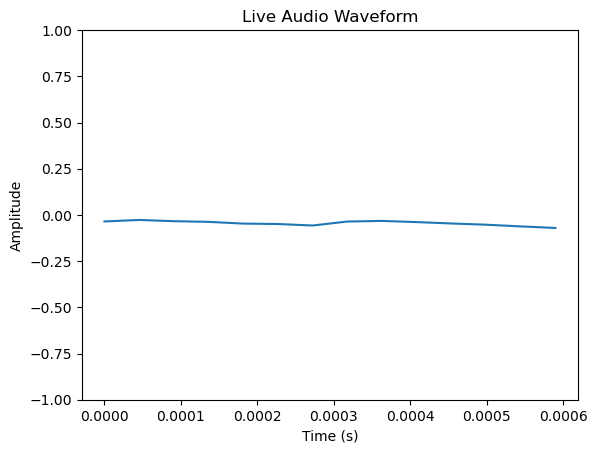

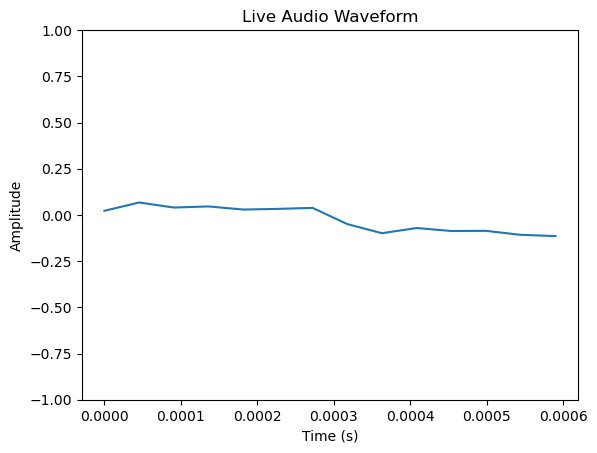

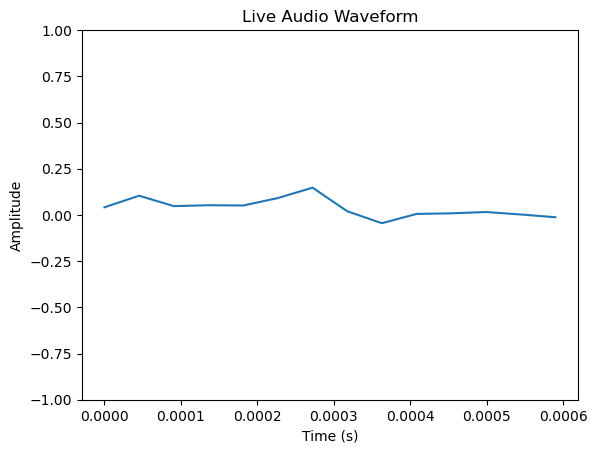

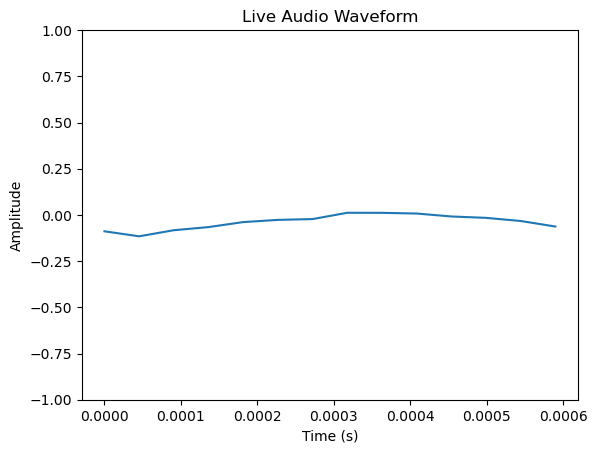

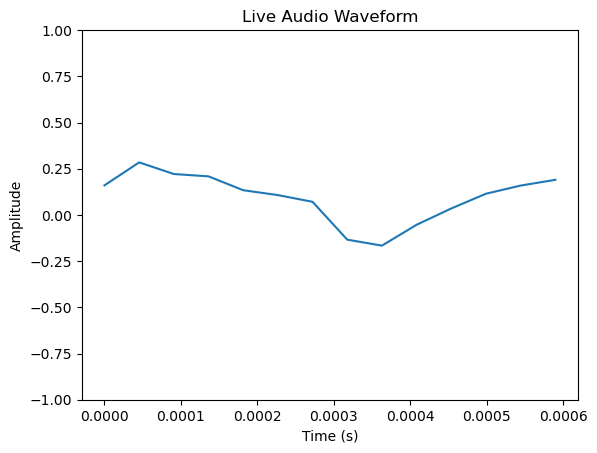

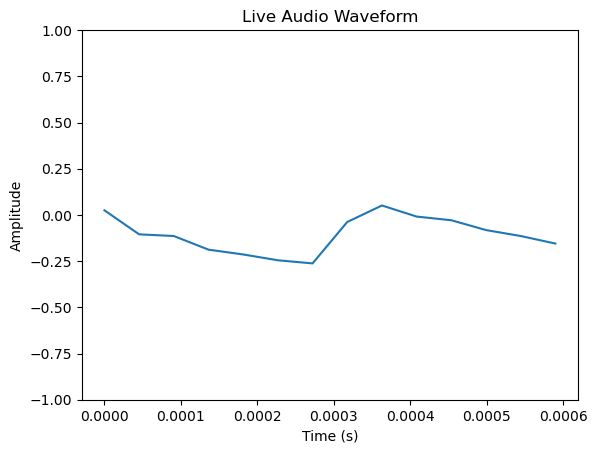

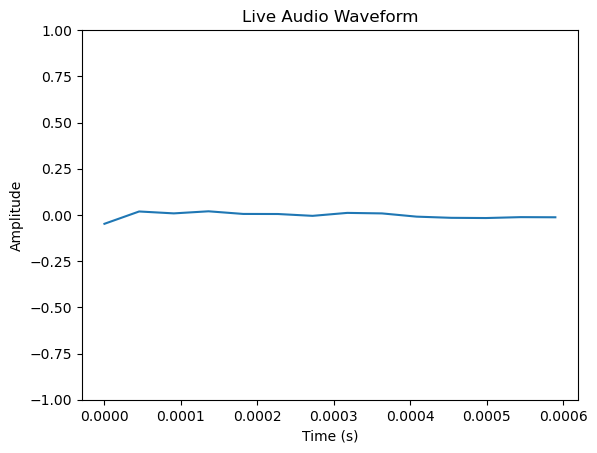

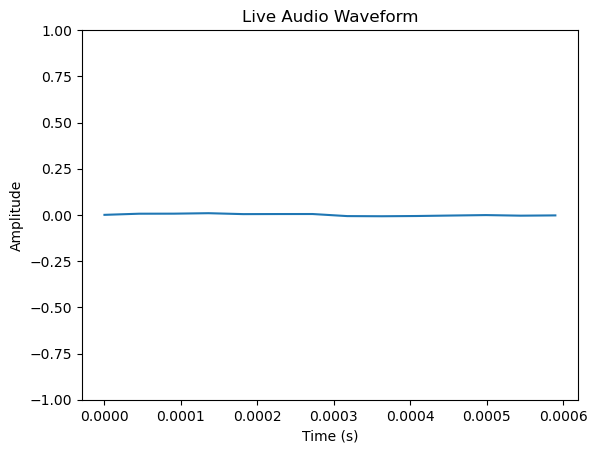

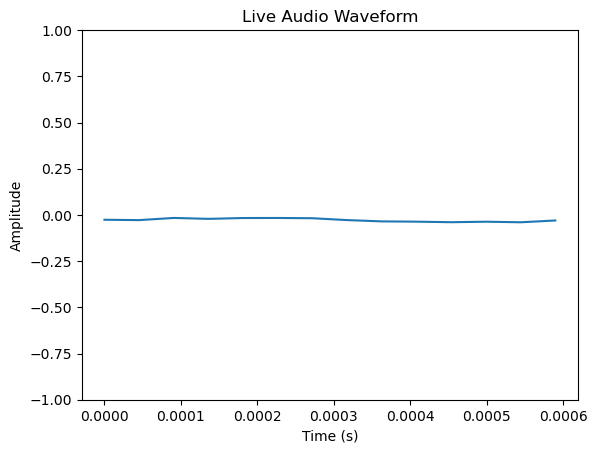

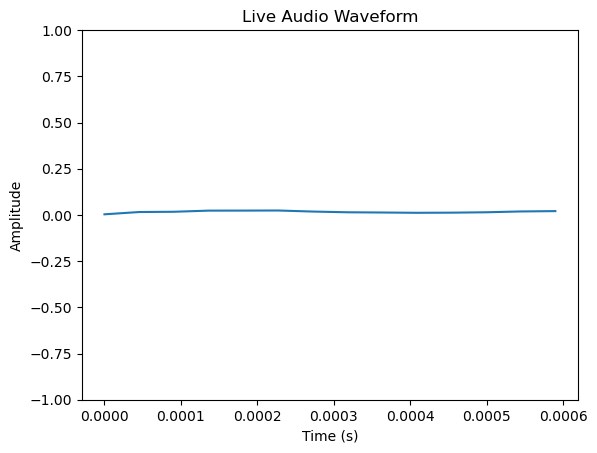

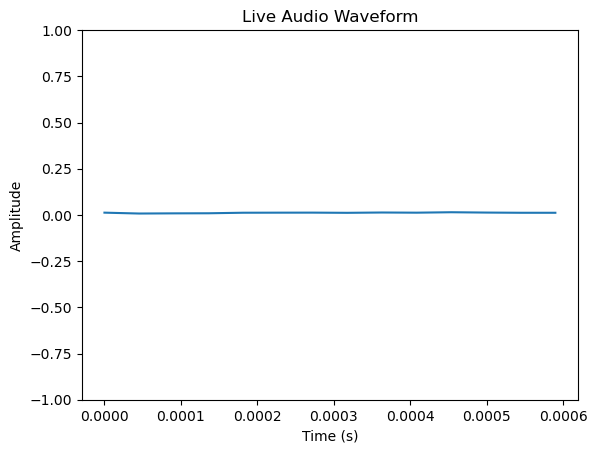

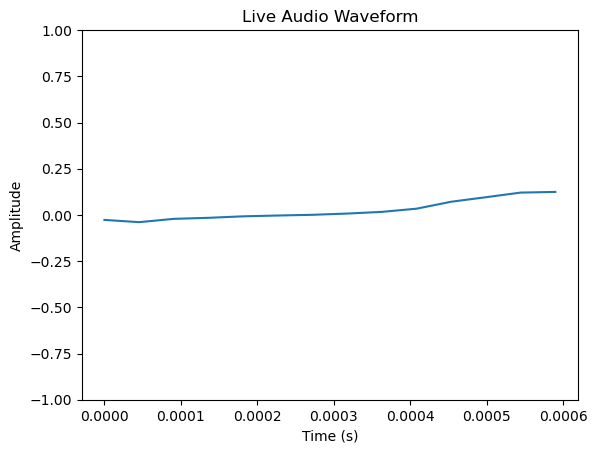

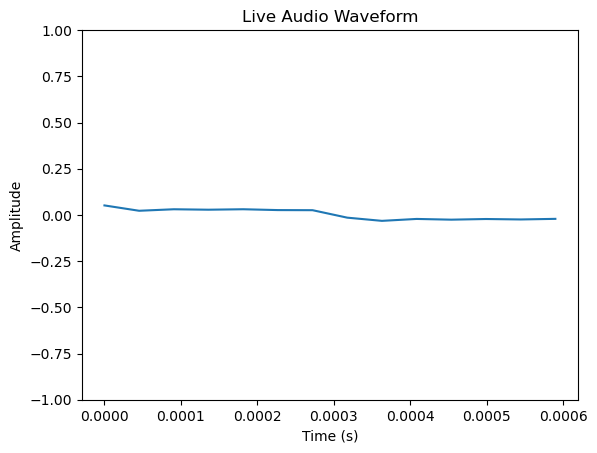

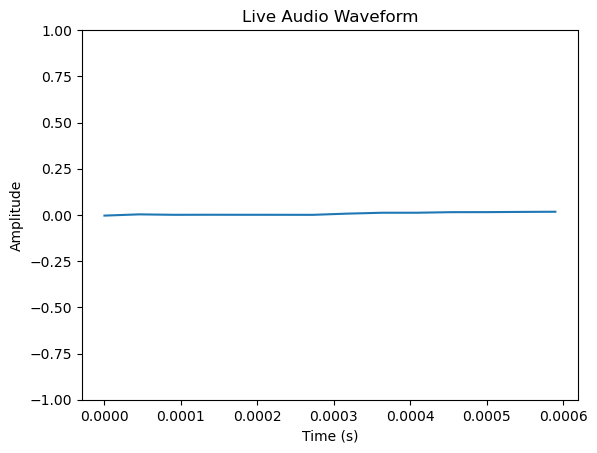

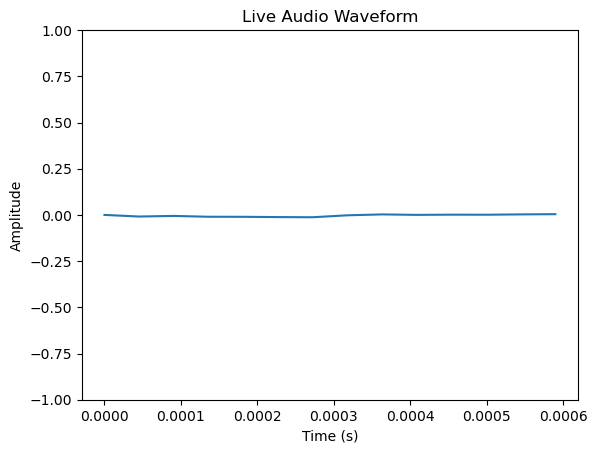

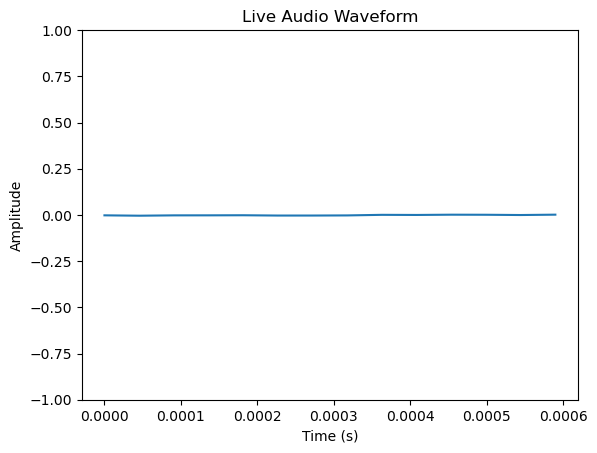

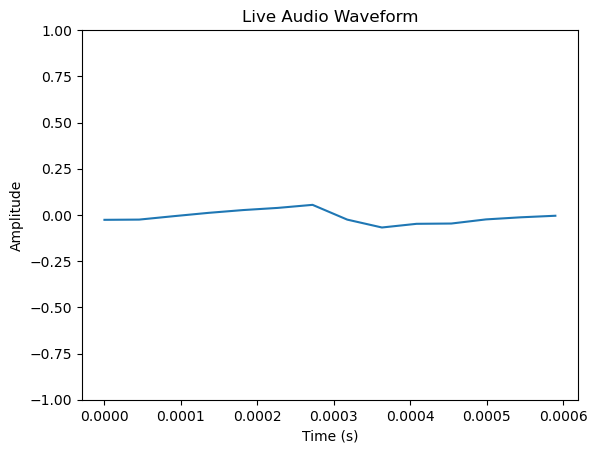

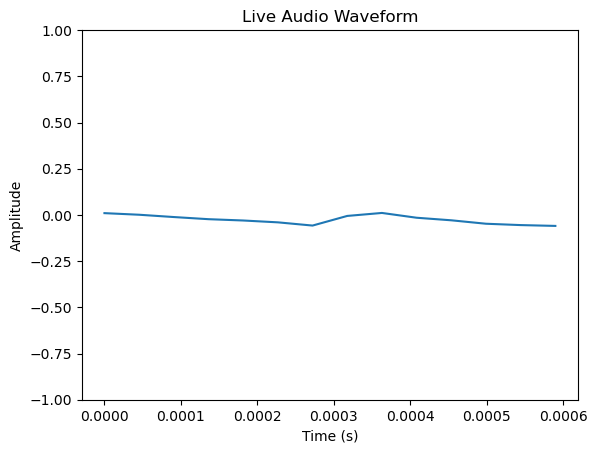

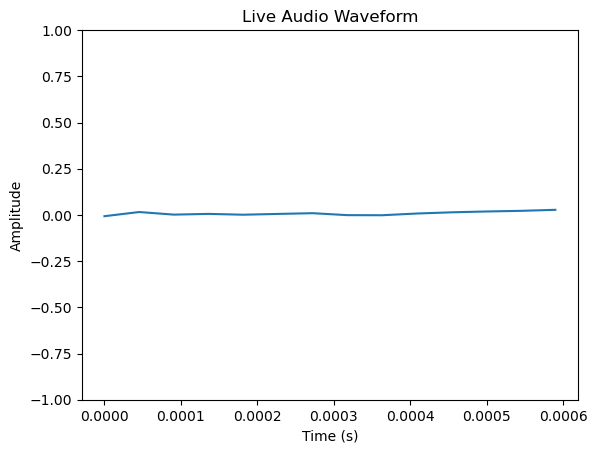

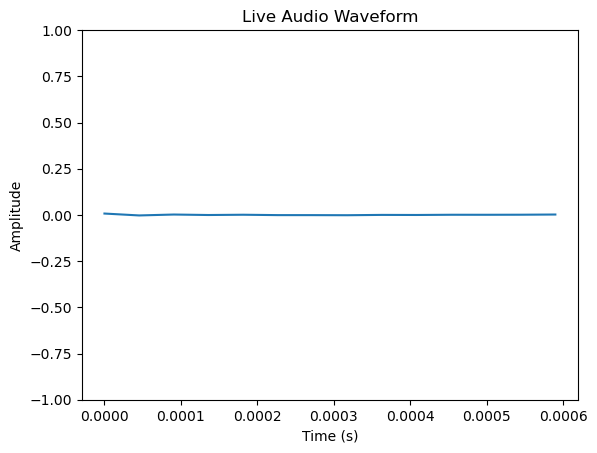

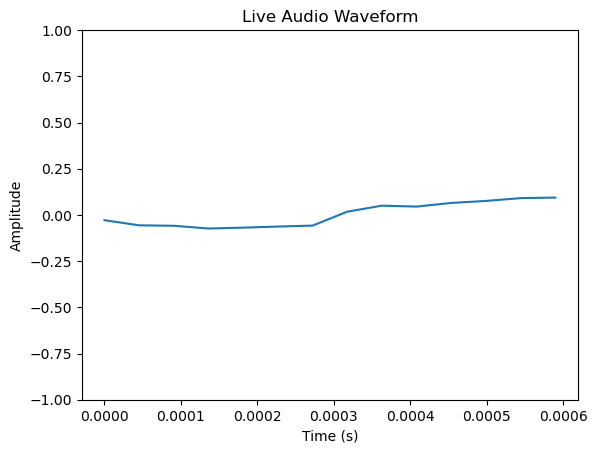

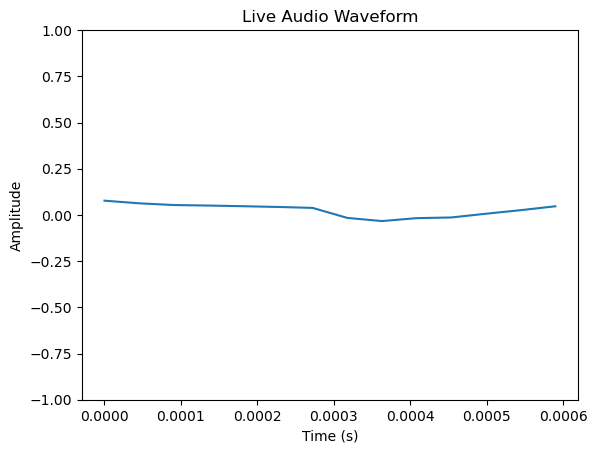

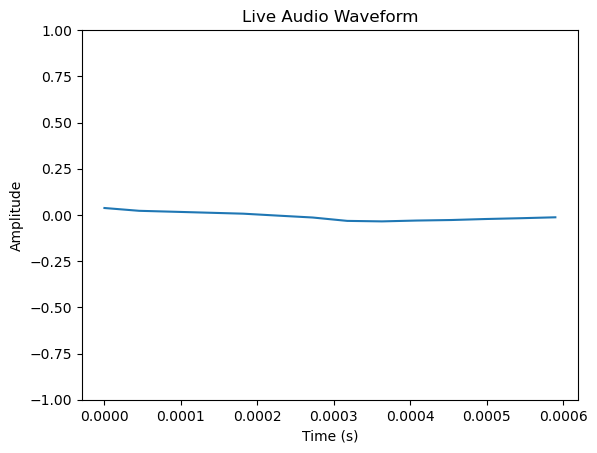

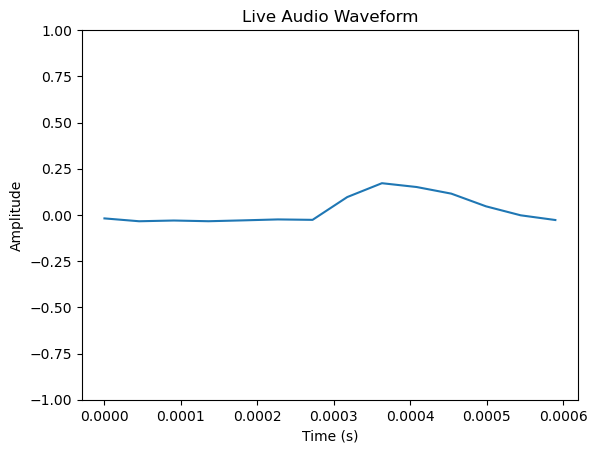

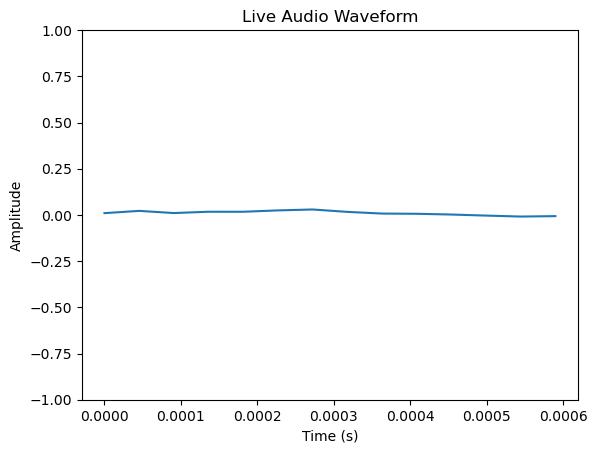

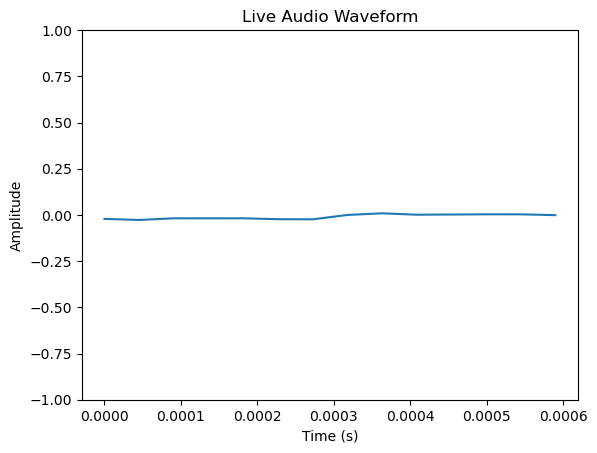

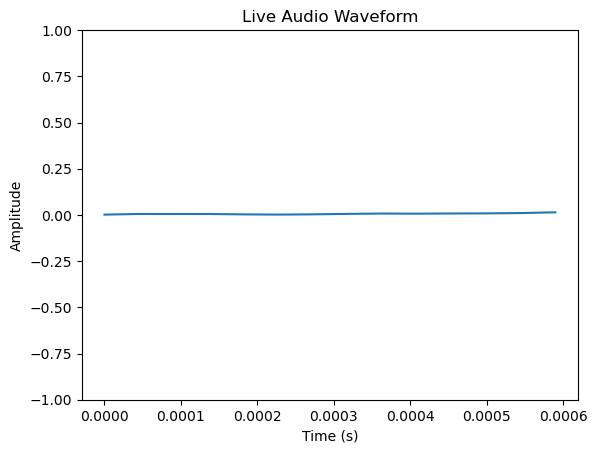

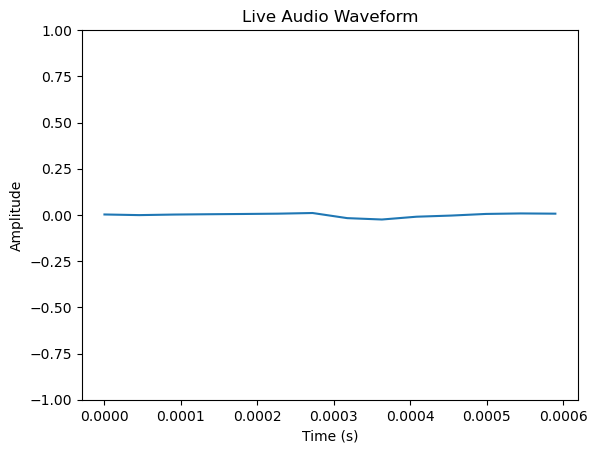

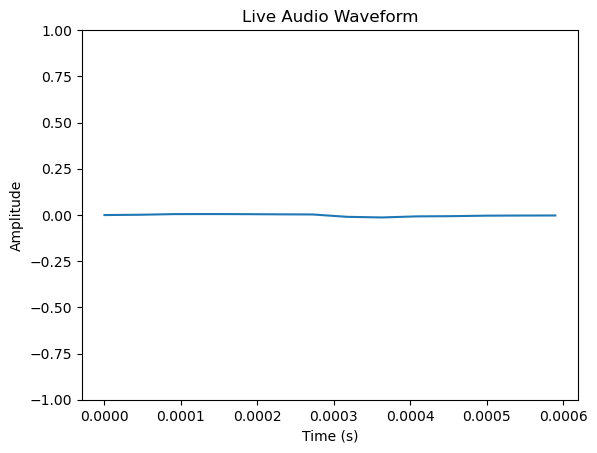

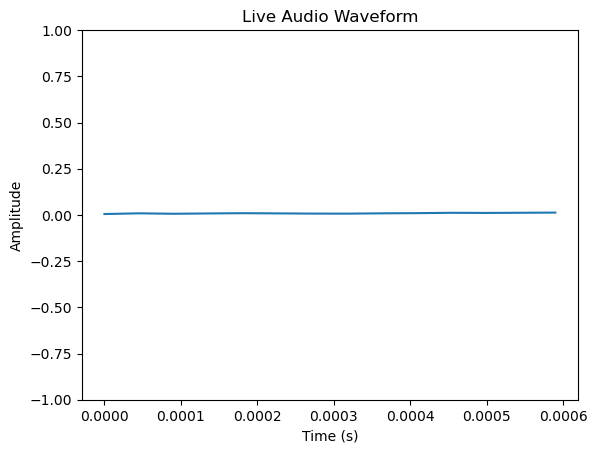

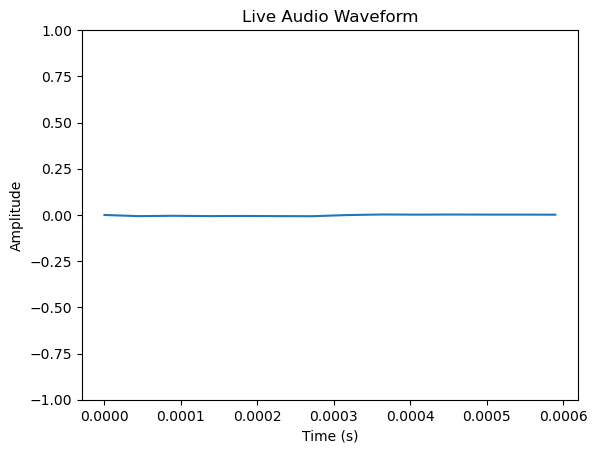

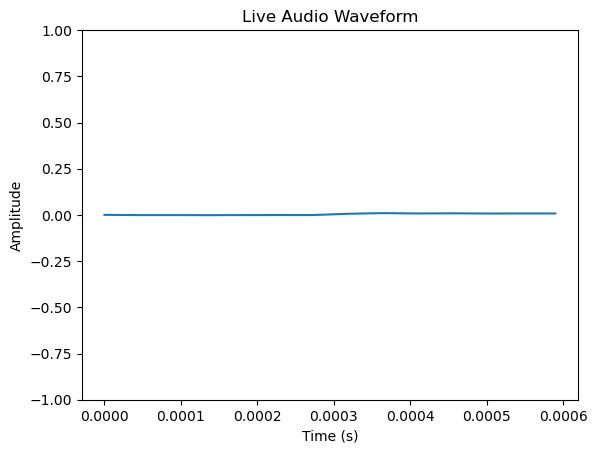

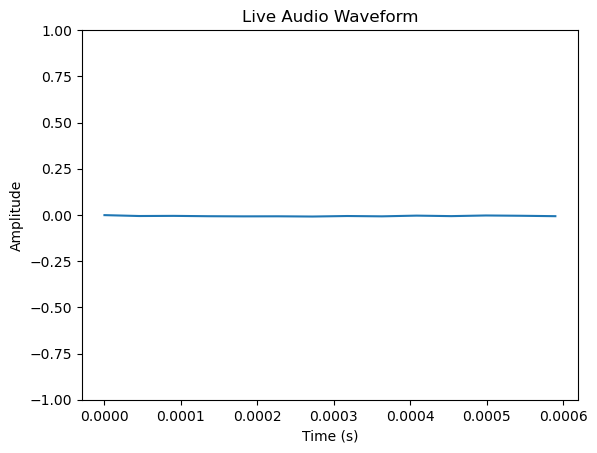

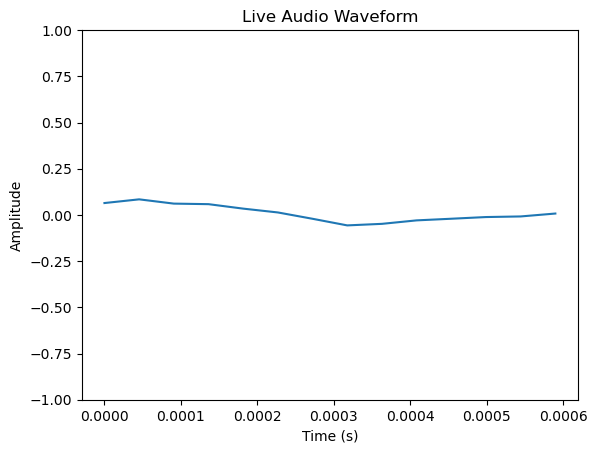

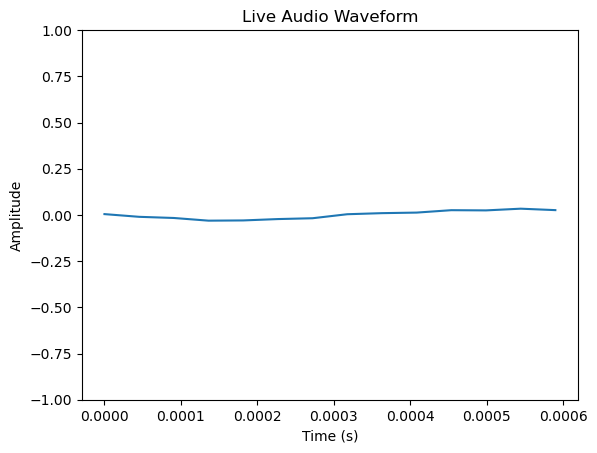

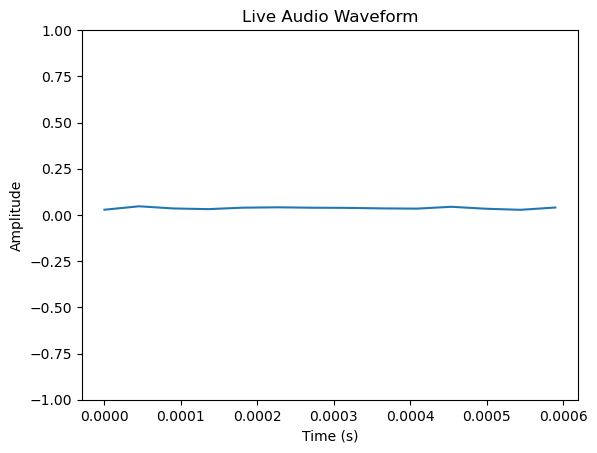

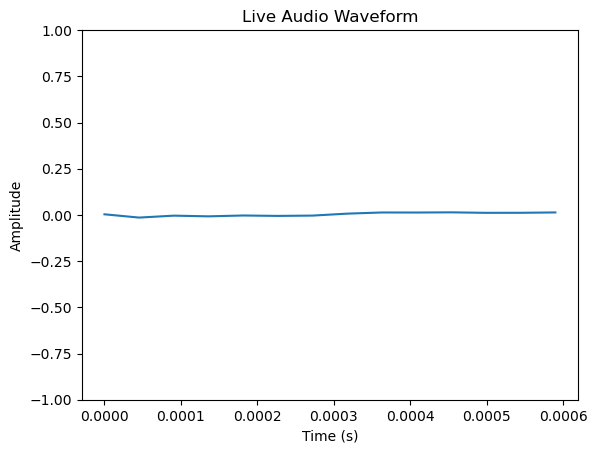

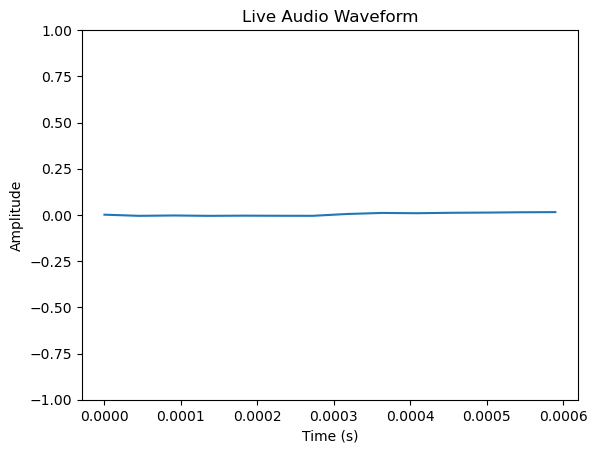

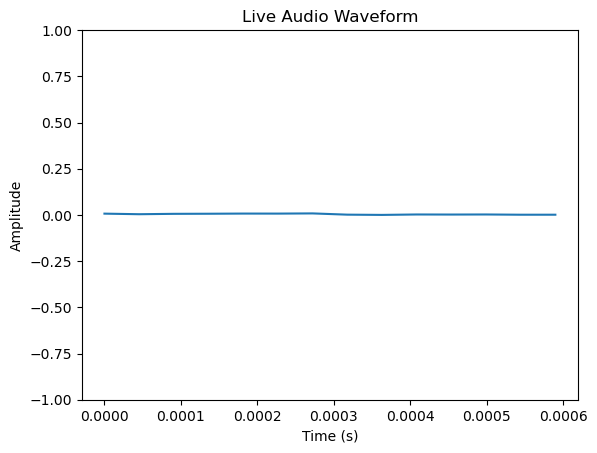

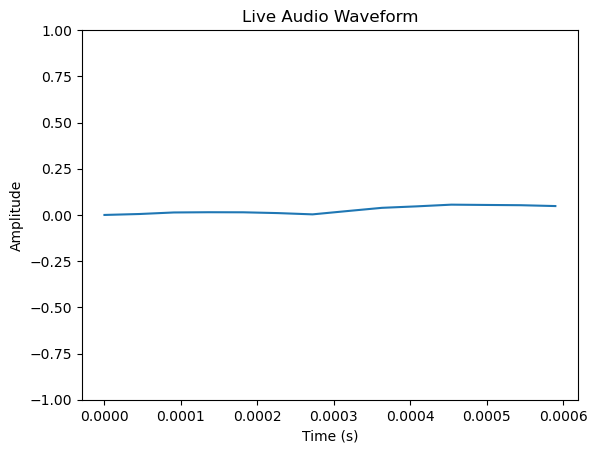

In [21]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import hilbert, savgol_filter

# Define parameters for audio recording
duration = 10  # Duration of audio recording in seconds
sample_rate = 22050  # Sample rate in Hz

# Function to handle audio input stream
def audio_callback(indata, frames, time, status):
    if status:
        print('Error:', status)
    # Plot the waveform
    plt.clf()
    plt.plot(np.arange(len(indata)) / sample_rate, indata)
    plt.title('Live Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(-1, 1)
    plt.pause(0.001)

    # plot the envelope
    analytic_signal = hilbert(indata[:, 0])
    envelope = np.abs(analytic_signal)
    envelope = savgol_filter(envelope, len(analytic_signal), 1)

    # plt.plot(np.arange(len(envelope)) / sample_rate, envelope)

# Start the audio stream
with sd.InputStream(callback=audio_callback,
                     samplerate=sample_rate,
                     channels=1):
    sd.sleep(int(duration * 1000))